In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   # ignore warning

# __1. 데이터 프레임 전처리__

In [2]:
dt = pd.read_csv('./03_oil_value_ts.csv')
dt.head(10)

Code Statistics        Fuel Type Sulfur Content Viscosity Delivery Type  \
0  PPXDK00      CLOSE         Fuel Oil           3.5%   380 CST           FOB   
1  PUABC00      CLOSE         Fuel Oil           3.5%   Unknown           FOB   
2  PUAFT00      CLOSE  Bunker Fuel Oil        Unknown   380 CST     Delivered   
3  AALMZ00      CLOSE    Marine Gasoil           0.5%   Unknown     Delivered   
4  PUAFN00      CLOSE  Bunker Fuel Oil           3.5%   380 CST     Delivered   
5  AAYWT00      CLOSE           Gasoil           0.1%   Unknown           FOB   
6  AARTG00      CLOSE    Marine Gasoil           0.1%   Unknown     Delivered   
7  AARKD00      CLOSE  Bunker Fuel Oil        Unknown   380 CST     Delivered   
8  AARKE00      CLOSE    Marine Gasoil           0.5%   Unknown     Delivered   
9  PUAFL00      CLOSE  Bunker Fuel Oil           3.5%   380 CST     Delivered   

    Location              Country Continent  2022-01-04  ...  2024-04-09  \
0  Singapore            Singapore      Asia      434.04  ...       491.9   
1  Rotterdam          Netherlands    Europe      430.50  ...       474.0   
2  Singapore            Singapore      Asia      447.00  ...       507.0   
3  Singapore            Singapore      Asia      684.00  ...       810.0   
4  Rotterdam          Netherlands    Europe      439.00  ...       475.0   
5  ARA Barge  Netherlands/Belgium    Europe      672.25  ...       816.0   
6  Rotterdam          Netherlands    Europe      670.00  ...       805.0   
7   Shanghai                China      Asia      505.00  ...       504.0   
8   Shanghai                China      Asia      785.00  ...       850.0   
9    Piraeus               Greece    Europe      468.00  ...       540.0   

   2024-04-10  2024-04-11  2024-04-12  2024-04-15  2024-04-16  2024-04-17  \
0     490.855      489.81      492.18      490.35      500.33      500.50   
1     466.750      472.50      479.00      472.00      485.00      482.75   
2     506.000      505.00      507.00      505.00      507.00      512.00   
3     810.000      810.00      803.00      798.00      805.00      801.00   
4     468.000      472.00      496.00      474.00      486.00      483.00   
5     801.250      800.50      816.75      794.00      795.50      784.75   
6     797.000      800.00      805.00      790.00      790.00      780.00   
7     504.500      505.00      510.00      507.00      518.00      521.00   
8     850.000      850.00      846.00      840.00      845.00      845.00   
9     535.000      535.00      535.00      540.00      535.00      540.00   

   2024-04-18  2024-04-19  2024-04-22  
0      495.32      499.21      489.36  
1      477.00      472.75      467.50  
2      509.00      513.00      507.00  
3      765.00      763.00      760.00  
4      477.00      476.00      469.00  
5      756.75      759.00      758.50  
6      760.00      750.00      750.00  
7      519.00      523.00      517.00  
8      833.00      825.00      820.00  
9      540.00      540.00      540.00  

[10 rows x 604 columns]

In [3]:
dt = dt[dt['Statistics'] == 'CLOSE'].drop(['Code', 'Country', 'Viscosity'], axis=1)

In [4]:
dt['Fuel Type'] = dt['Fuel Type'] + ' ' + (dt.groupby('Fuel Type').cumcount() + 1).astype(str)
dt

Statistics          Fuel Type Sulfur Content Delivery Type   Location  \
0       CLOSE         Fuel Oil 1           3.5%           FOB  Singapore   
1       CLOSE         Fuel Oil 2           3.5%           FOB  Rotterdam   
2       CLOSE  Bunker Fuel Oil 1        Unknown     Delivered  Singapore   
3       CLOSE    Marine Gasoil 1           0.5%     Delivered  Singapore   
4       CLOSE  Bunker Fuel Oil 2           3.5%     Delivered  Rotterdam   
..        ...                ...            ...           ...        ...   
86      CLOSE         Fuel Oil 5           3.5%           CIF  Med Cargo   
89      CLOSE           Gasoil 6           0.1%           CIF  Med Cargo   
92      CLOSE           Gasoil 7           0.1%           CIF  NWE Cargo   
94      CLOSE      Marine Fuel 3           0.5%     Delivered     Santos   
95      CLOSE   Marine Gasoil 37           0.1%     Delivered     Santos   

        Continent  2022-01-04  2022-01-05  2022-01-06  2022-01-07  ...  \
0            Asia      434.04      436.28      438.37      450.78  ...   
1          Europe      430.50      437.75      444.00      442.00  ...   
2            Asia      447.00      449.00      451.00      463.00  ...   
3            Asia      684.00      694.00      698.00      709.00  ...   
4          Europe      439.00      445.00      456.00      456.00  ...   
..            ...         ...         ...         ...         ...  ...   
86         Europe      436.00      442.00      449.75      446.75  ...   
89         Europe      690.50      706.75      715.25      715.50  ...   
92         Europe         NaN         NaN         NaN         NaN  ...   
94  South America         NaN         NaN         NaN         NaN  ...   
95  South America         NaN         NaN         NaN         NaN  ...   

    2024-04-09  2024-04-10  2024-04-11  2024-04-12  2024-04-15  2024-04-16  \
0       491.90     490.855      489.81      492.18      490.35      500.33   
1       474.00     466.750      472.50      479.00      472.00      485.00   
2       507.00     506.000      505.00      507.00      505.00      507.00   
3       810.00     810.000      810.00      803.00      798.00      805.00   
4       475.00     468.000      472.00      496.00      474.00      486.00   
..         ...         ...         ...         ...         ...         ...   
86      493.50     491.250      498.25      505.50      498.50      506.00   
89      835.75     831.000      830.50      846.00      822.25      821.75   
92      821.25     813.250      813.00      829.00      806.25      808.00   
94      676.00     677.000      670.00      672.00      668.00      670.00   
95      914.00     917.000      912.00      915.00      905.00      904.00   

    2024-04-17  2024-04-18  2024-04-19  2024-04-22  
0       500.50      495.32      499.21      489.36  
1       482.75      477.00      472.75      467.50  
2       512.00      509.00      513.00      507.00  
3       801.00      765.00      763.00      760.00  
4       483.00      477.00      476.00      469.00  
..         ...         ...         ...         ...  
86      501.75      496.00      492.00      487.75  
89      810.75      779.00      781.00      783.00  
92      797.50      770.50      773.00      772.25  
94      664.00      659.00      661.00      649.00  
95      900.00      896.00      899.00      884.00  

[82 rows x 601 columns]

In [5]:
date_columns = dt.columns[6:]
date_columns

Index(['2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-10',
       '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-17',
       ...
       '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15',
       '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22'],
      dtype='object', length=595)

In [6]:
dt_fuel = dt.loc[:, date_columns].T
dt_fuel.columns = dt['Fuel Type']
dt_fuel.index = pd.to_datetime(dt_fuel.index)
dt_fuel

Fuel Type   Fuel Oil 1  Fuel Oil 2  Bunker Fuel Oil 1  Marine Gasoil 1  \
2022-01-04      434.04      430.50              447.0            684.0   
2022-01-05      436.28      437.75              449.0            694.0   
2022-01-06      438.37      444.00              451.0            698.0   
2022-01-07      450.78      442.00              463.0            709.0   
2022-01-10      448.57      437.25              461.0            712.0   
...                ...         ...                ...              ...   
2024-04-16      500.33      485.00              507.0            805.0   
2024-04-17      500.50      482.75              512.0            801.0   
2024-04-18      495.32      477.00              509.0            765.0   
2024-04-19      499.21      472.75              513.0            763.0   
2024-04-22      489.36      467.50              507.0            760.0   

Fuel Type   Bunker Fuel Oil 2  Gasoil 1  Marine Gasoil 2  Bunker Fuel Oil 3  \
2022-01-04              439.0    672.25            670.0              505.0   
2022-01-05              445.0    692.25            685.0              508.0   
2022-01-06              456.0    701.25            703.0              510.0   
2022-01-07              456.0    702.25            700.0              520.0   
2022-01-10              451.0    698.75            702.0              515.0   
...                       ...       ...              ...                ...   
2024-04-16              486.0    795.50            790.0              518.0   
2024-04-17              483.0    784.75            780.0              521.0   
2024-04-18              477.0    756.75            760.0              519.0   
2024-04-19              476.0    759.00            750.0              523.0   
2024-04-22              469.0    758.50            750.0              517.0   

Fuel Type   Marine Gasoil 3  Bunker Fuel Oil 4  ...  Marine Fuel 2  \
2022-01-04            785.0              468.0  ...         569.00   
2022-01-05            785.0              470.0  ...         576.00   
2022-01-06            785.0              473.0  ...         581.50   
2022-01-07            797.0              475.0  ...         581.50   
2022-01-10            790.0              479.0  ...         582.50   
...                     ...                ...  ...            ...   
2024-04-16            845.0              535.0  ...         622.25   
2024-04-17            845.0              540.0  ...         614.75   
2024-04-18            833.0              540.0  ...         602.25   
2024-04-19            825.0              540.0  ...         602.00   
2024-04-22            820.0              540.0  ...         596.00   

Fuel Type   Bunker Fuel Oil 28  Marine Gasoil 36  Fuel Oil 4  Gasoil 5  \
2022-01-04               493.0             715.0      427.50    673.75   
2022-01-05               495.0             720.0      433.75    690.75   
2022-01-06               501.0             730.0      441.50    699.25   
2022-01-07               502.0             740.0      438.00    700.25   
2022-01-10               505.0             740.0      433.00    698.50   
...                        ...               ...         ...       ...   
2024-04-16               583.0             853.0      494.00    802.50   
2024-04-17               577.0             850.0      489.75    789.25   
2024-04-18               570.0             830.0      484.00    758.00   
2024-04-19               570.0             825.0      480.00    761.00   
2024-04-22               570.0             817.0      475.75    765.75   

Fuel Type   Fuel Oil 5  Gasoil 6  Gasoil 7  Marine Fuel 3  Marine Gasoil 37  
2022-01-04      436.00    690.50       NaN            NaN               NaN  
2022-01-05      442.00    706.75       NaN            NaN               NaN  
2022-01-06      449.75    715.25       NaN            NaN               NaN  
2022-01-07      446.75    715.50       NaN            NaN               NaN  
2022-01-10      441.75    713.25       NaN

In [7]:
# 결측치 컬럼 삭제
dt_fuel = dt_fuel.iloc[:, :-3]
dt_fuel

Fuel Type   Fuel Oil 1  Fuel Oil 2  Bunker Fuel Oil 1  Marine Gasoil 1  \
2022-01-04      434.04      430.50              447.0            684.0   
2022-01-05      436.28      437.75              449.0            694.0   
2022-01-06      438.37      444.00              451.0            698.0   
2022-01-07      450.78      442.00              463.0            709.0   
2022-01-10      448.57      437.25              461.0            712.0   
...                ...         ...                ...              ...   
2024-04-16      500.33      485.00              507.0            805.0   
2024-04-17      500.50      482.75              512.0            801.0   
2024-04-18      495.32      477.00              509.0            765.0   
2024-04-19      499.21      472.75              513.0            763.0   
2024-04-22      489.36      467.50              507.0            760.0   

Fuel Type   Bunker Fuel Oil 2  Gasoil 1  Marine Gasoil 2  Bunker Fuel Oil 3  \
2022-01-04              439.0    672.25            670.0              505.0   
2022-01-05              445.0    692.25            685.0              508.0   
2022-01-06              456.0    701.25            703.0              510.0   
2022-01-07              456.0    702.25            700.0              520.0   
2022-01-10              451.0    698.75            702.0              515.0   
...                       ...       ...              ...                ...   
2024-04-16              486.0    795.50            790.0              518.0   
2024-04-17              483.0    784.75            780.0              521.0   
2024-04-18              477.0    756.75            760.0              519.0   
2024-04-19              476.0    759.00            750.0              523.0   
2024-04-22              469.0    758.50            750.0              517.0   

Fuel Type   Marine Gasoil 3  Bunker Fuel Oil 4  ...  Marine Gasoil 34  \
2022-01-04            785.0              468.0  ...             699.0   
2022-01-05            785.0              470.0  ...             715.0   
2022-01-06            785.0              473.0  ...             734.0   
2022-01-07            797.0              475.0  ...             725.0   
2022-01-10            790.0              479.0  ...             735.0   
...                     ...                ...  ...               ...   
2024-04-16            845.0              535.0  ...             860.0   
2024-04-17            845.0              540.0  ...             850.0   
2024-04-18            833.0              540.0  ...             835.0   
2024-04-19            825.0              540.0  ...             855.0   
2024-04-22            820.0              540.0  ...             825.0   

Fuel Type   Marine Gasoil 35  Marine Fuel 1  Marine Fuel 2  \
2022-01-04             705.0         561.50         569.00   
2022-01-05             705.0         568.50         576.00   
2022-01-06             705.0         574.00         581.50   
2022-01-07             705.0         573.75         581.50   
2022-01-10             710.0         574.75         582.50   
...                      ...            ...            ...   
2024-04-16             717.0         611.50         622.25   
2024-04-17             717.0         604.00         614.75   
2024-04-18             716.0         591.50         602.25   
2024-04-19             717.0         591.25         602.00   
2024-04-22             690.0         585.25         596.00   

Fuel Type   Bunker Fuel Oil 28  Marine Gasoil 36  Fuel Oil 4  Gasoil 5  \
2022-01-04               493.0             715.0      427.50    673.75   
2022-01-05               495.0             720.0      433.75    690.75   
2022-01-06               501.0             730.0      441.50    699.25   
2022-01-07               502.0             740.0      438.00    700.25   
2022-01-10               505.0             740.0      433.00    698.50   
...                        ...               ...         ...       ...   
2024-04-16            

In [8]:
dt_fuel_mg = dt_fuel.filter(regex='Marine Gasoil')
dt_fuel_mg

Fuel Type   Marine Gasoil 1  Marine Gasoil 2  Marine Gasoil 3  \
2022-01-04            684.0            670.0            785.0   
2022-01-05            694.0            685.0            785.0   
2022-01-06            698.0            703.0            785.0   
2022-01-07            709.0            700.0            797.0   
2022-01-10            712.0            702.0            790.0   
...                     ...              ...              ...   
2024-04-16            805.0            790.0            845.0   
2024-04-17            801.0            780.0            845.0   
2024-04-18            765.0            760.0            833.0   
2024-04-19            763.0            750.0            825.0   
2024-04-22            760.0            750.0            820.0   

Fuel Type   Marine Gasoil 4  Marine Gasoil 5  Marine Gasoil 6  \
2022-01-04            701.0            700.0            735.0   
2022-01-05            710.0            705.0            755.0   
2022-01-06            711.0            709.0            760.0   
2022-01-07            720.0            715.0            770.0   
2022-01-10            720.0            718.0            795.0   
...                     ...              ...              ...   
2024-04-16            880.0            808.0            900.0   
2024-04-17            875.0            808.0            900.0   
2024-04-18            865.0            782.0            890.0   
2024-04-19            855.0            772.0            875.0   
2024-04-22            847.0            772.0            875.0   

Fuel Type   Marine Gasoil 7  Marine Gasoil 8  Marine Gasoil 9  \
2022-01-04           708.25            777.0            775.5   
2022-01-05           722.25            778.0            800.5   
2022-01-06           715.00            785.0            802.5   
2022-01-07           733.00            786.0            806.5   
2022-01-10           736.00            792.0            813.5   
...                     ...              ...              ...   
2024-04-16           816.50            911.0            876.5   
2024-04-17           814.50            893.0            865.5   
2024-04-18           799.50            883.0            859.5   
2024-04-19           792.50            884.0            860.5   
2024-04-22           792.25            887.0            861.5   

Fuel Type   Marine Gasoil 10  ...  Marine Gasoil 27  Marine Gasoil 28  \
2022-01-04             757.0  ...             797.0             809.0   
2022-01-05             782.0  ...             822.0             834.0   
2022-01-06             784.0  ...             824.0             836.0   
2022-01-07             788.0  ...             828.0             840.0   
2022-01-10             795.0  ...             835.0             847.0   
...                      ...  ...               ...               ...   
2024-04-16             858.0  ...             869.0             881.0   
2024-04-17             847.0  ...             858.0             870.0   
2024-04-18             841.0  ...             852.0             864.0   
2024-04-19             842.0  ...             853.0             865.0   
2024-04-22             843.0  ...             854.0             866.0   

Fuel Type   Marine Gasoil 29  Marine Gasoil 30  Marine Gasoil 31  \
2022-01-04             754.0             713.0             670.0   
2022-01-05             762.0             727.0             685.0   
2022-01-06             773.0             747.0             703.0   
2022-01-07             768.0             749.0             700.0   
2022-01-10             775.0             750.0             702.0   
...                      ...               ...               ...   
2024-04-16             900.0             865.0             790.0   
2024-04-17             890.0             860.0             780.0   
2024-04-18             880.0             850.0             760.0   
2024-04-19             878.0             840.0             750.0   
2024-04-22             870.0    

# __2. 시계열 데이터 전처리__

In [9]:
ts = dt_fuel_mg['Marine Gasoil 9']
ts = pd.DataFrame(ts)
ts.index.name = 'Date'
ts.rename(columns={'Marine Gasoil 9': 'Marine Gasoil 9_Price'}, inplace=True)
ts

Marine Gasoil 9_Price
Date                             
2022-01-04                  775.5
2022-01-05                  800.5
2022-01-06                  802.5
2022-01-07                  806.5
2022-01-10                  813.5
...                           ...
2024-04-16                  876.5
2024-04-17                  865.5
2024-04-18                  859.5
2024-04-19                  860.5
2024-04-22                  861.5

[595 rows x 1 columns]

In [10]:
ts.to_csv('05_MG9_ts.csv')

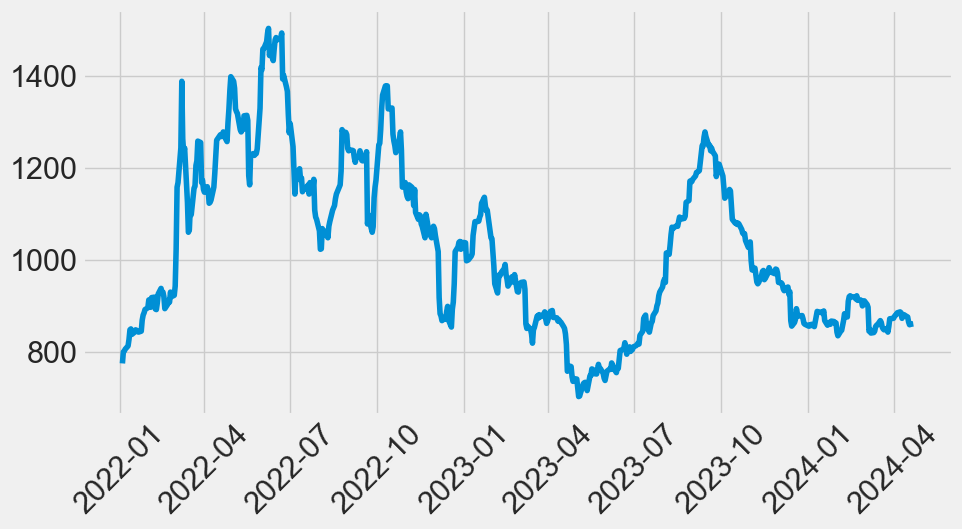

In [11]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plt.xticks(rotation=45)
plt.plot(ts);

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, period=20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

# __3. 데이터 분리__

In [13]:
last_date = ts.index.max()
last_date

Timestamp('2024-04-22 00:00:00')

In [14]:
test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape

((585, 1), (10, 1))

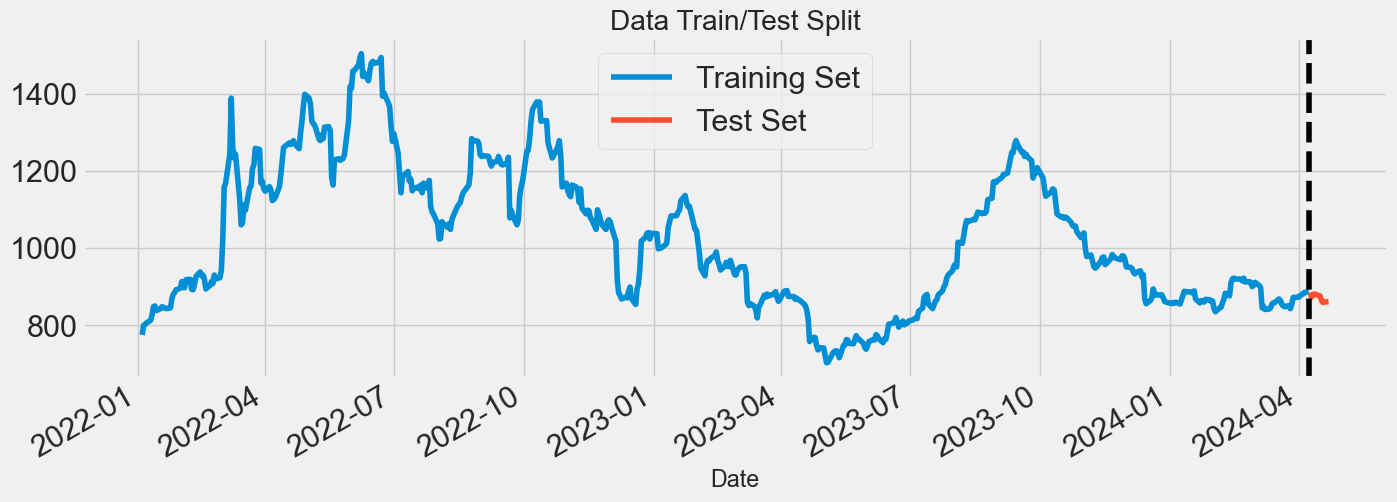

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
train_val.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(test_start_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

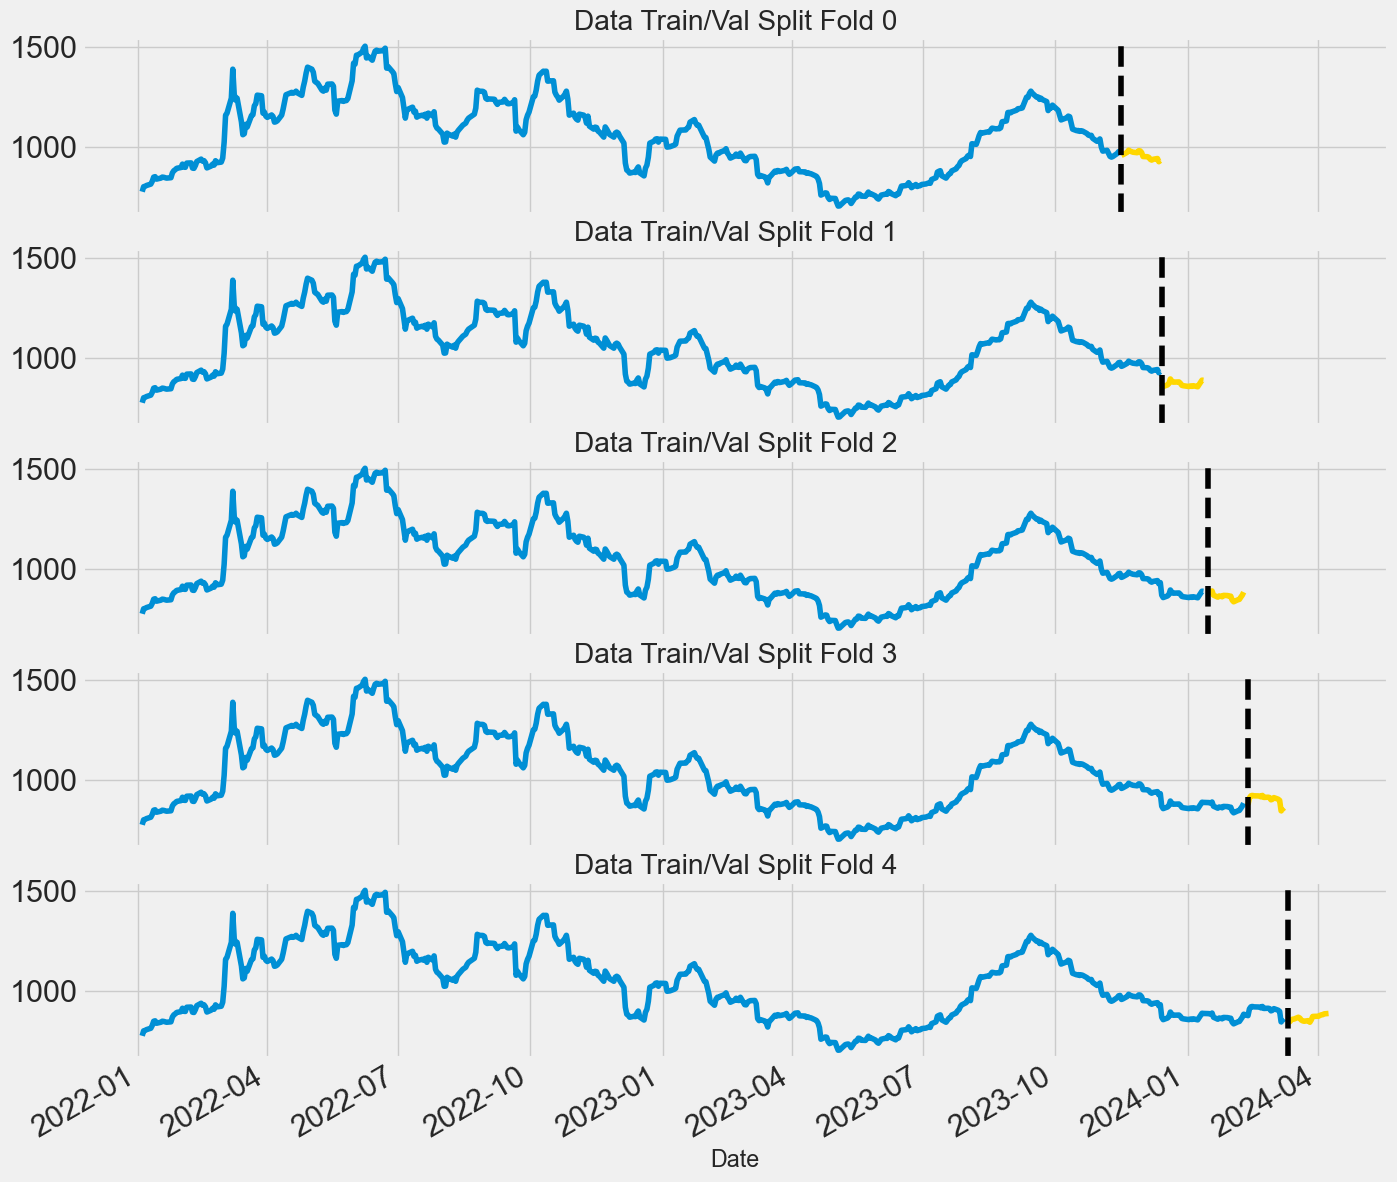

In [16]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 5, test_size=20)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(train_val):
    train = train_val.iloc[train_idx]
    validation = train_val.iloc[val_idx]
    train['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Val Split Fold {fold}')
    validation['Marine Gasoil 9_Price'].plot(ax=axs[fold], label='Test Set', color='gold')
    axs[fold].axvline(validation.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [17]:
train_val.shape, test.shape

((585, 1), (10, 1))

# __4. Feature Engineering__

## __4.1 Trend, Seasonal__

In [18]:
train_val['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
train_val['seasonal'] = seasonal
train_val.head(20)

Marine Gasoil 9_Price    trend  seasonal
Date                                                
2022-01-04                  775.5  846.550 -1.554101
2022-01-05                  800.5  846.550 -3.835135
2022-01-06                  802.5  846.550 -1.155825
2022-01-07                  806.5  846.550  1.645037
2022-01-10                  813.5  846.550  6.737278
2022-01-11                  827.5  846.550 -2.680333
2022-01-12                  848.5  846.550 -2.934797
2022-01-13                  850.5  846.550 -2.422594
2022-01-14                  838.5  846.550 -5.157713
2022-01-17                  843.5  846.550 -5.649083
2022-01-18                  848.5  846.550 -8.482262
2022-01-19                  847.5  852.450 -3.621917
2022-01-20                  845.5  857.275 -0.534848
2022-01-21                  843.5  862.450  4.334692
2022-01-24                  845.5  867.900  6.254520
2022-01-25                  869.5  872.200  1.778658
2022-01-26                  880.5  874.950 -1.292894
2022-01-27                  885.5  877.450  7.299347
2022-01-28                  892.5  881.050  6.496761
2022-01-31                  896.5  885.625  4.775209

In [19]:
test['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
test['seasonal'] = seasonal
test.shape

(10, 3)

## __4.2 Moving Averages__

In [20]:
# 이동평균을 추가하는 함수
def add_rolling_mean(df:pd.DataFrame, col_name:str, window_list:list)->pd.DataFrame:
    for window in window_list:
        df[col_name + f'_rolling{window}'] = df[col_name].rolling(window).mean().fillna(method='bfill')
    return df

In [21]:
# 5일(1주), 10일(2주), 20일(1개월), 60일(3개월), 120일(6개월), 240일(1년) 이동평균 추가
train_val = add_rolling_mean(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
train_val.head(20)

Marine Gasoil 9_Price    trend  seasonal  \
Date                                                   
2022-01-04                  775.5  846.550 -1.554101   
2022-01-05                  800.5  846.550 -3.835135   
2022-01-06                  802.5  846.550 -1.155825   
2022-01-07                  806.5  846.550  1.645037   
2022-01-10                  813.5  846.550  6.737278   
2022-01-11                  827.5  846.550 -2.680333   
2022-01-12                  848.5  846.550 -2.934797   
2022-01-13                  850.5  846.550 -2.422594   
2022-01-14                  838.5  846.550 -5.157713   
2022-01-17                  843.5  846.550 -5.649083   
2022-01-18                  848.5  846.550 -8.482262   
2022-01-19                  847.5  852.450 -3.621917   
2022-01-20                  845.5  857.275 -0.534848   
2022-01-21                  843.5  862.450  4.334692   
2022-01-24                  845.5  867.900  6.254520   
2022-01-25                  869.5  872.200  1.778658   
2022-01-26                  880.5  874.950 -1.292894   
2022-01-27                  885.5  877.450  7.299347   
2022-01-28                  892.5  881.050  6.496761   
2022-01-31                  896.5  885.625  4.775209   

            Marine Gasoil 9_Price_rolling5  Marine Gasoil 9_Price_rolling10  \
Date                                                                          
2022-01-04                           799.7                            820.7   
2022-01-05                           799.7                            820.7   
2022-01-06                           799.7                            820.7   
2022-01-07                           799.7                            820.7   
2022-01-10                           799.7                            820.7   
2022-01-11                           810.1                            820.7   
2022-01-12                           819.7                            820.7   
2022-01-13                           829.3                            820.7   
2022-01-14                           835.7                            820.7   
2022-01-17                           841.7                            820.7   
2022-01-18                           845.9                            828.0   
2022-01-19                           845.7                            832.7   
2022-01-20                           844.7                            837.0   
2022-01-21                           845.7                            840.7   
2022-01-24                           846.1                            843.9   
2022-01-25                           850.3                            848.1   
2022-01-26                           856.9                            851.3   
2022-01-27                           864.9                            854.8   
2022-01-28                           874.7                            860.2   
2022-01-31                           884.9                            865.5   

            Marine Gasoil 9_Price_rolling20  Marine Gasoil 9_Price_rolling60  \
Date                                                                           
2022-01-04                            843.1                          975.375   
2022-01-05                            843.1                          975.375   
2022-01-06                            843.1                          975.375   
2022-01-07                            843.1                          975.375   
2022-01-10                            843.1                          975.375   
2022-01-11                            843.1                          975.375   
2022-01-12                            843.1                          975.375   
2022-01-13                            843.1                          975.375   
2022-01-14                            843.1                          975.375   
2022-01-17                            843.1                          975.375   
2022-01-18                            843.1                          975.375   


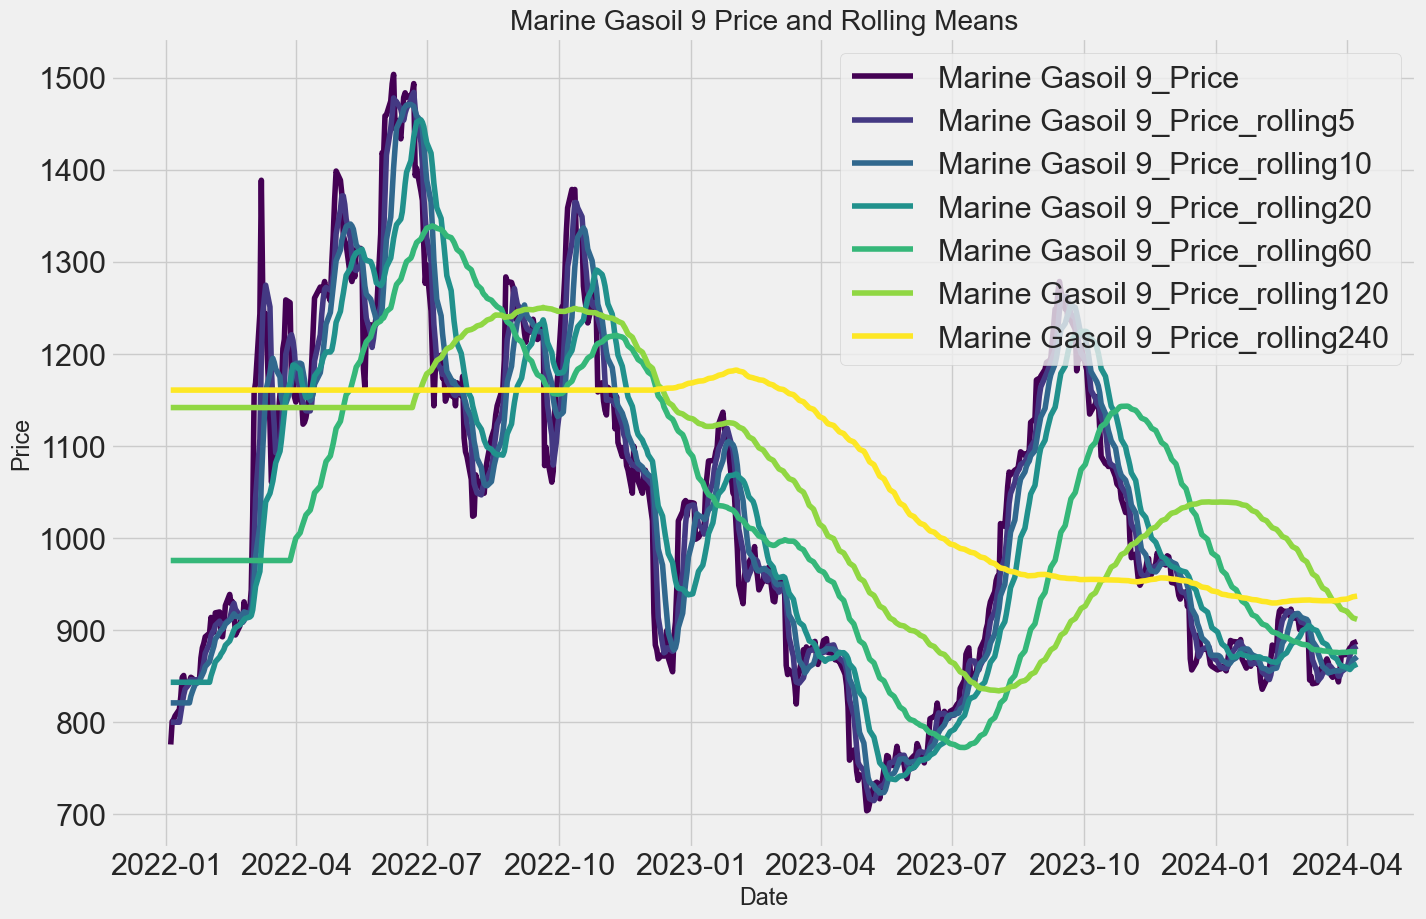

In [22]:
columns_to_plot = [
    'Marine Gasoil 9_Price',
    'Marine Gasoil 9_Price_rolling5',
    'Marine Gasoil 9_Price_rolling10',
    'Marine Gasoil 9_Price_rolling20',
    'Marine Gasoil 9_Price_rolling60',
    'Marine Gasoil 9_Price_rolling120',
    'Marine Gasoil 9_Price_rolling240'
]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [23]:
test = add_rolling_mean(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
test.shape

(10, 9)

## __4.3 Lag feature__

In [24]:
def add_lags(df: pd.DataFrame, col_name: str, lag_days_list: list) -> pd.DataFrame:
    target_map = df[col_name].to_dict()
    for days in lag_days_list:
        df[f'{col_name}_lag{days}'] = (df.index - pd.Timedelta(days=days)).map(target_map)
    df = df.fillna(method='bfill').fillna(method='ffill')
    return df

In [25]:
train_val = add_lags(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240, 480])
test = add_lags(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240, 480])

In [26]:
train_val

Marine Gasoil 9_Price    trend  seasonal  \
Date                                                   
2022-01-04                  775.5  846.550 -1.554101   
2022-01-05                  800.5  846.550 -3.835135   
2022-01-06                  802.5  846.550 -1.155825   
2022-01-07                  806.5  846.550  1.645037   
2022-01-10                  813.5  846.550  6.737278   
...                           ...      ...       ...   
2024-04-02                  877.5  869.800 -1.554101   
2024-04-03                  880.5  870.025 -3.835135   
2024-04-04                  881.5  870.175 -1.155825   
2024-04-05                  885.5  870.550  1.645037   
2024-04-08                  887.5  871.125  6.737278   

            Marine Gasoil 9_Price_rolling5  Marine Gasoil 9_Price_rolling10  \
Date                                                                          
2022-01-04                           799.7                            820.7   
2022-01-05                           799.7                            820.7   
2022-01-06                           799.7                            820.7   
2022-01-07                           799.7                            820.7   
2022-01-10                           799.7                            820.7   
...                                    ...                              ...   
2024-04-02                           864.5                            859.2   
2024-04-03                           871.9                            860.8   
2024-04-04                           877.1                            863.5   
2024-04-05                           879.7                            867.0   
2024-04-08                           882.5                            870.9   

            Marine Gasoil 9_Price_rolling20  Marine Gasoil 9_Price_rolling60  \
Date                                                                           
2022-01-04                           843.10                       975.375000   
2022-01-05                           843.10                       975.375000   
2022-01-06                           843.10                       975.375000   
2022-01-07                           843.10                       975.375000   
2022-01-10                           843.10                       975.375000   
...                                     ...                              ...   
2024-04-02                           857.80                       876.083333   
2024-04-03                           856.95                       876.316667   
2024-04-04                           858.75                       876.383333   
2024-04-05                           860.55                       876.333333   
2024-04-08                           862.85                       876.333333   

            Marine Gasoil 9_Price_rolling120  \
Date                                           
2022-01-04                       1141.545833   
2022-01-05                       1141.545833   
2022-01-06                       1141.545833   
2022-01-07                       1141.545833   
2022-01-10                       1141.545833   
...                                      ...   
2024-04-02                        918.108333   
2024-04-03                        916.375000   
2024-04-04                        914.716667   
2024-04-05                        913.083333   
2024-04-08                        911.500000   

            Marine Gasoil 9_Price_rolling240  Marine Gasoil 9_Price_lag5  \
Date                                                                       
2022-01-04                       1160.531250                       800.5   
2022-01-05                       1160.531250                       800.5   
2022-01-06                       1160.531250                       800.5   
2022-01-07                       1160.531250                       800.5   
2022-01-10                       1160.531250                       800.5   
...                                      ...             

In [27]:
train_val.shape, test.shape

((585, 16), (10, 16))

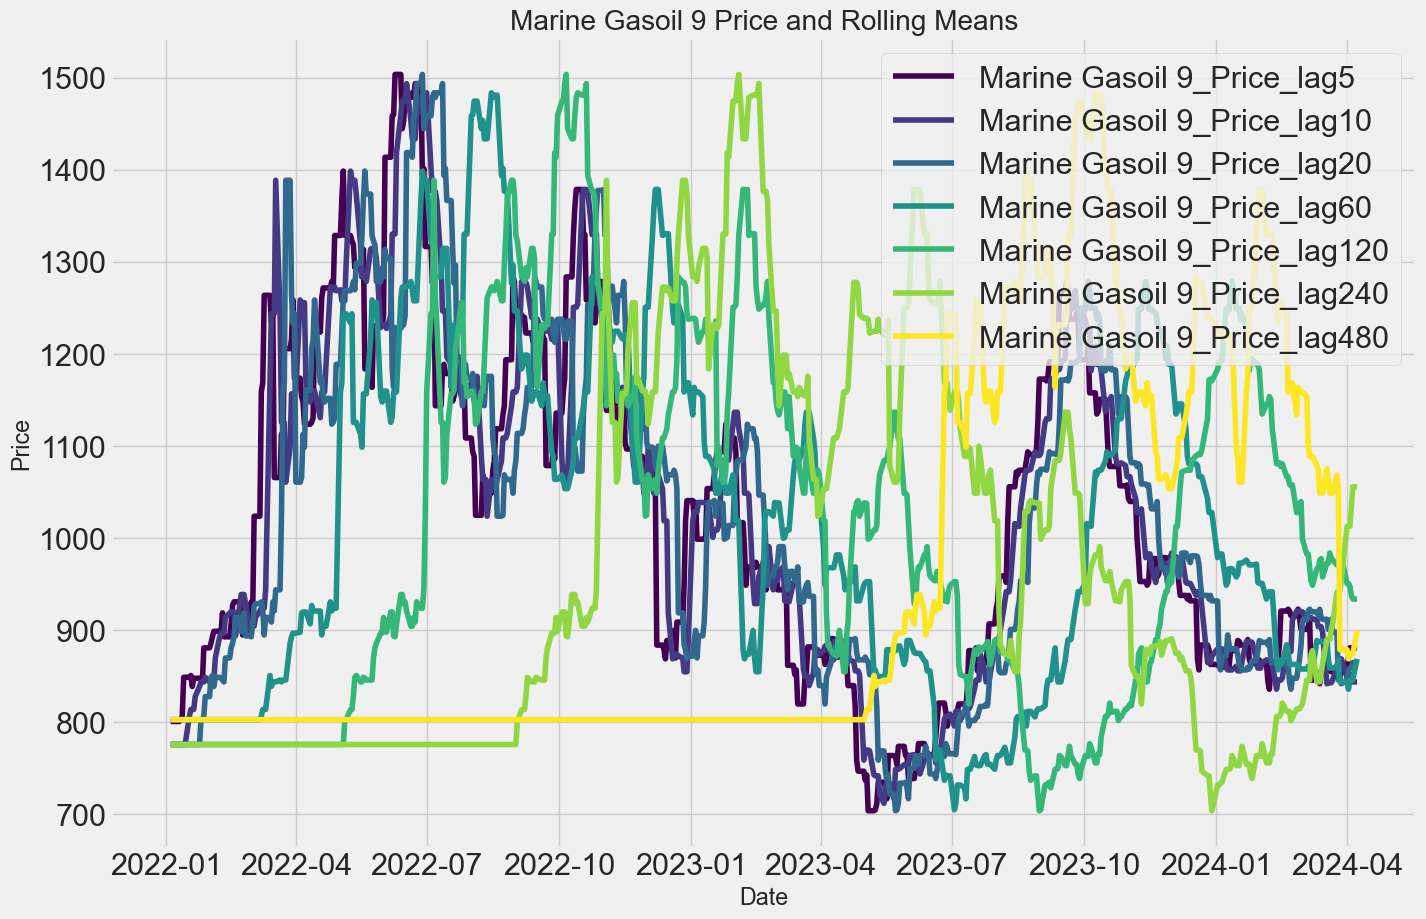

In [28]:
columns_to_plot = [
    'Marine Gasoil 9_Price_lag5',
    'Marine Gasoil 9_Price_lag10',
    'Marine Gasoil 9_Price_lag20',
    'Marine Gasoil 9_Price_lag60',
    'Marine Gasoil 9_Price_lag120',
    'Marine Gasoil 9_Price_lag240',
    'Marine Gasoil 9_Price_lag480'
]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## __4.4 dummies__

In [29]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

In [30]:
test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [31]:
train_val

Marine Gasoil 9_Price    trend  seasonal  \
Date                                                   
2022-01-04                  775.5  846.550 -1.554101   
2022-01-05                  800.5  846.550 -3.835135   
2022-01-06                  802.5  846.550 -1.155825   
2022-01-07                  806.5  846.550  1.645037   
2022-01-10                  813.5  846.550  6.737278   
...                           ...      ...       ...   
2024-04-02                  877.5  869.800 -1.554101   
2024-04-03                  880.5  870.025 -3.835135   
2024-04-04                  881.5  870.175 -1.155825   
2024-04-05                  885.5  870.550  1.645037   
2024-04-08                  887.5  871.125  6.737278   

            Marine Gasoil 9_Price_rolling5  Marine Gasoil 9_Price_rolling10  \
Date                                                                          
2022-01-04                           799.7                            820.7   
2022-01-05                           799.7                            820.7   
2022-01-06                           799.7                            820.7   
2022-01-07                           799.7                            820.7   
2022-01-10                           799.7                            820.7   
...                                    ...                              ...   
2024-04-02                           864.5                            859.2   
2024-04-03                           871.9                            860.8   
2024-04-04                           877.1                            863.5   
2024-04-05                           879.7                            867.0   
2024-04-08                           882.5                            870.9   

            Marine Gasoil 9_Price_rolling20  Marine Gasoil 9_Price_rolling60  \
Date                                                                           
2022-01-04                           843.10                       975.375000   
2022-01-05                           843.10                       975.375000   
2022-01-06                           843.10                       975.375000   
2022-01-07                           843.10                       975.375000   
2022-01-10                           843.10                       975.375000   
...                                     ...                              ...   
2024-04-02                           857.80                       876.083333   
2024-04-03                           856.95                       876.316667   
2024-04-04                           858.75                       876.383333   
2024-04-05                           860.55                       876.333333   
2024-04-08                           862.85                       876.333333   

            Marine Gasoil 9_Price_rolling120  \
Date                                           
2022-01-04                       1141.545833   
2022-01-05                       1141.545833   
2022-01-06                       1141.545833   
2022-01-07                       1141.545833   
2022-01-10                       1141.545833   
...                                      ...   
2024-04-02                        918.108333   
2024-04-03                        916.375000   
2024-04-04                        914.716667   
2024-04-05                        913.083333   
2024-04-08                        911.500000   

            Marine Gasoil 9_Price_rolling240  Marine Gasoil 9_Price_lag5  ...  \
Date                                                                      ...   
2022-01-04                       1160.531250                       800.5  ...   
2022-01-05                       1160.531250                       800.5  ...   
2022-01-06                       1160.531250                       800.5  ...   
2022-01-07                       1160.531250                       800.5  ...   
2022-01-10                       1160.531250                       800.5  ...   
...                   

# __5. Machine Learning__

In [32]:
validation_start_date = test_start_date - pd.Timedelta(days=30)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((565, 23), (20, 23), (10, 23))

In [33]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [34]:
# 모델 정의
xgb_model = XGBRegressor(
    base_score=0.5, booster='gbtree',
    n_estimators=10000, early_stopping_rounds=50,
    objective='reg:linear', max_depth=6,
    learning_rate=0.01, min_child_weight=1,
    subsample=0.8, colsample_bytree=0.8,
    gamma=0, reg_alpha=0, reg_lambda=1,
    random_state=42
)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']
tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1229.78463
[100]	validation_0-rmse:480.63349
[200]	validation_0-rmse:220.04083
[300]	validation_0-rmse:140.28654
[400]	validation_0-rmse:116.33448
[500]	validation_0-rmse:109.33673
[600]	validation_0-rmse:106.95746
[700]	validation_0-rmse:106.05583
[800]	validation_0-rmse:105.37245
[900]	validation_0-rmse:105.05198
[1000]	validation_0-rmse:104.85490
[1100]	validation_0-rmse:104.77482
[1200]	validation_0-rmse:104.68884
[1300]	validation_0-rmse:104.64372
[1342]	validation_0-rmse:104.64262
[0]	validation_0-rmse:1068.99740
[100]	validation_0-rmse:403.14462
[200]	validation_0-rmse:158.50832
[300]	validation_0-rmse:78.34782
[400]	validation_0-rmse:57.46993
[500]	validation_0-rmse:53.56299
[600]	validation_0-rmse:53.16885
[608]	validation_0-rmse:53.15250
[0]	validation_0-rmse:811.08028
[100]	validation_0-rmse:258.77994
[200]	validation_0-rmse:85.31054
[300]	validation_0-rmse:41.27152
[387]	validation_0-rmse:41.31106
[0]	validation_0-rmse:1058.67381
[100]	validation_0-rms

In [36]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [79.28898447567654, 44.23138176043009, 34.34956595823937, 23.01485419519169, 12.077593931217784]
Average MAE across folds: 38.59
RMSE for each fold: [104.63708039732305, 53.142801216865855, 39.659460624202815, 28.531290537988546, 15.87173408585906]
Average RMSE across folds: 48.37
MAPE for each fold: [6.201090041131648, 4.270928902878335, 4.264658731384992, 2.186306613189411, 1.3638652922535799]
Average MAPE across folds: 3.66


In [37]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:880.29629
[100]	validation_0-rmse:322.74985
[200]	validation_0-rmse:119.08197
[300]	validation_0-rmse:46.69728
[400]	validation_0-rmse:23.43817
[500]	validation_0-rmse:17.64151
[600]	validation_0-rmse:16.24464
[700]	validation_0-rmse:15.89355
[800]	validation_0-rmse:15.88646
[900]	validation_0-rmse:15.90255
[905]	validation_0-rmse:15.89579


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [38]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

Marine Gasoil 9_Price  prediction_xgb_val_cv  prediction_xgb_cv
Date                                                                       
2022-01-04                  775.5                    NaN                NaN
2022-01-05                  800.5                    NaN                NaN
2022-01-06                  802.5                    NaN                NaN
2022-01-07                  806.5                    NaN                NaN
2022-01-10                  813.5                    NaN                NaN
...                           ...                    ...                ...
2024-04-16                  876.5                    NaN         842.522644
2024-04-17                  865.5                    NaN         846.026184
2024-04-18                  859.5                    NaN         847.547791
2024-04-19                  860.5                    NaN         849.928223
2024-04-22                  861.5                    NaN         848.352295

[595 rows x 3 columns]

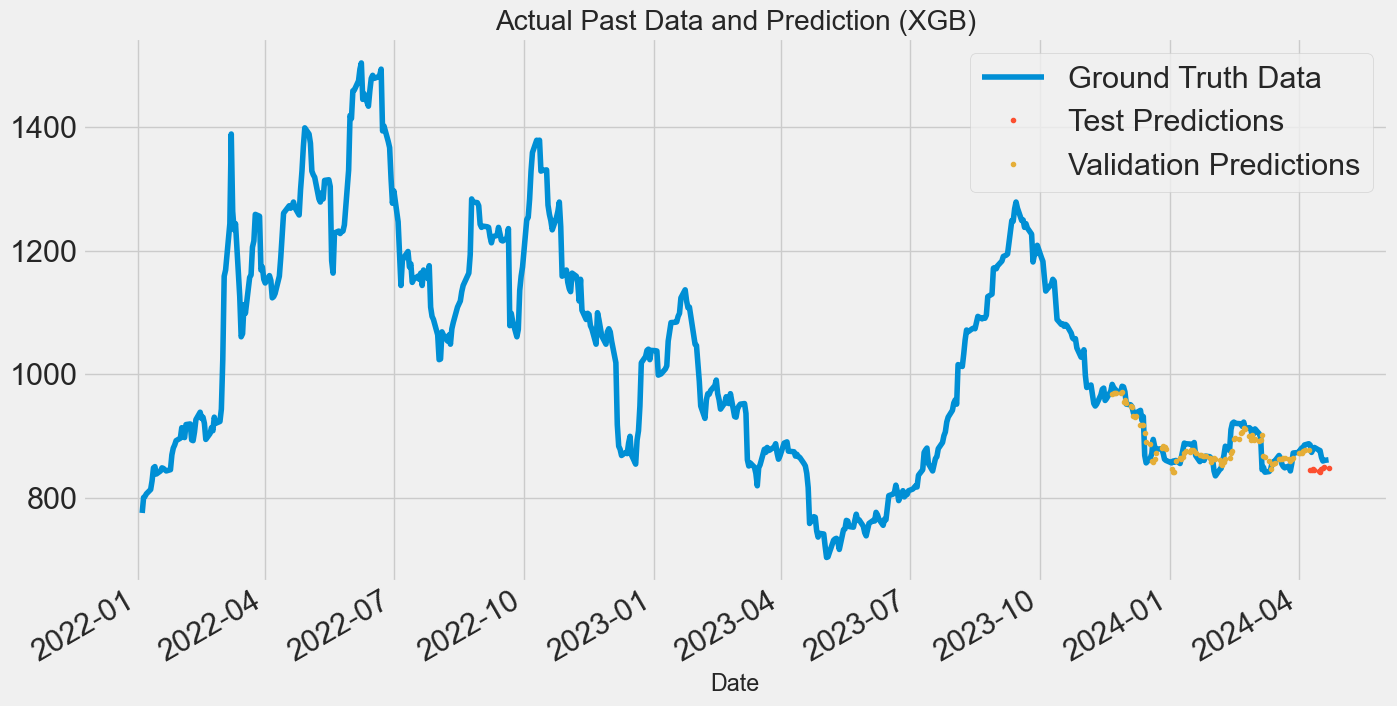

In [39]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb_cv'].plot(ax=ax, style='.')
ts['prediction_xgb_val_cv'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

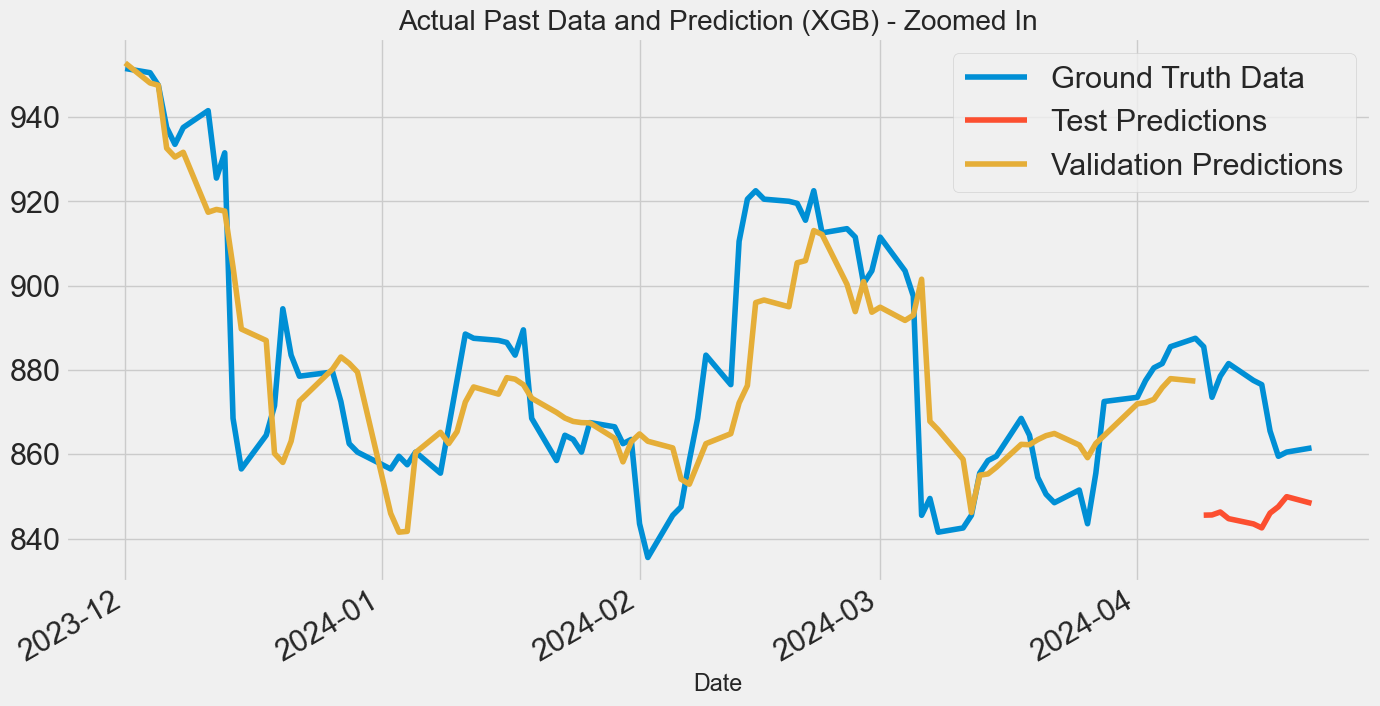

In [40]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-12-01'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_xgb_cv'].plot(ax=ax, style='-')
ts_zoomed['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 12.08
RMSE Score on Validation set (XGB): 15.87
MAPE Score on Validation set (XGB): 1.36%


In [42]:
ts_clean = ts.dropna(subset=['prediction_xgb_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 26.00
RMSE Score on Validation set (XGB): 28.08
MAPE Score on Validation set (XGB): 2.97%


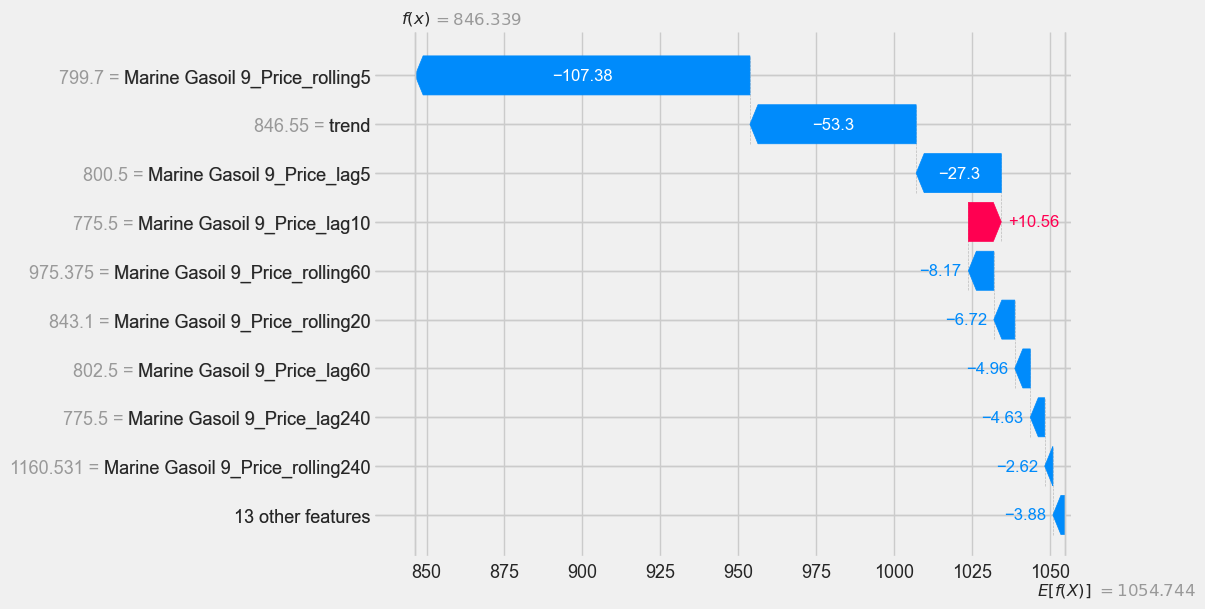

In [43]:
import shap

xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

In [44]:
test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape


validation_start_date = test_start_date - pd.Timedelta(days=30)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((565, 3), (20, 3), (10, 3))

# __Experiments__

## __Trial 1. SMA 일부 사용__

In [81]:
ts1 = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts1.index = pd.to_datetime(ts1.index)
ts1

Marine Gasoil 9_Price
Date                             
2022-01-04                  775.5
2022-01-05                  800.5
2022-01-06                  802.5
2022-01-07                  806.5
2022-01-10                  813.5
...                           ...
2024-04-16                  876.5
2024-04-17                  865.5
2024-04-18                  859.5
2024-04-19                  860.5
2024-04-22                  861.5

[595 rows x 1 columns]

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1, period=20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

In [83]:
last_date = ts1.index.max()

test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts1.loc[ts1.index <= test_start_date]
test = ts1.loc[ts1.index > test_start_date]

train_val.shape, test.shape

((585, 1), (10, 1))

In [84]:
train_val['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
train_val['seasonal'] = seasonal
train_val.head(20)

Marine Gasoil 9_Price    trend  seasonal
Date                                                
2022-01-04                  775.5  846.550 -1.554101
2022-01-05                  800.5  846.550 -3.835135
2022-01-06                  802.5  846.550 -1.155825
2022-01-07                  806.5  846.550  1.645037
2022-01-10                  813.5  846.550  6.737278
2022-01-11                  827.5  846.550 -2.680333
2022-01-12                  848.5  846.550 -2.934797
2022-01-13                  850.5  846.550 -2.422594
2022-01-14                  838.5  846.550 -5.157713
2022-01-17                  843.5  846.550 -5.649083
2022-01-18                  848.5  846.550 -8.482262
2022-01-19                  847.5  852.450 -3.621917
2022-01-20                  845.5  857.275 -0.534848
2022-01-21                  843.5  862.450  4.334692
2022-01-24                  845.5  867.900  6.254520
2022-01-25                  869.5  872.200  1.778658
2022-01-26                  880.5  874.950 -1.292894
2022-01-27                  885.5  877.450  7.299347
2022-01-28                  892.5  881.050  6.496761
2022-01-31                  896.5  885.625  4.775209

In [85]:
test['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
test['seasonal'] = seasonal

In [86]:
train_val = add_rolling_mean(train_val, 'Marine Gasoil 9_Price', [5, 10, 20])
train_val.head(20)

Marine Gasoil 9_Price    trend  seasonal  \
Date                                                   
2022-01-04                  775.5  846.550 -1.554101   
2022-01-05                  800.5  846.550 -3.835135   
2022-01-06                  802.5  846.550 -1.155825   
2022-01-07                  806.5  846.550  1.645037   
2022-01-10                  813.5  846.550  6.737278   
2022-01-11                  827.5  846.550 -2.680333   
2022-01-12                  848.5  846.550 -2.934797   
2022-01-13                  850.5  846.550 -2.422594   
2022-01-14                  838.5  846.550 -5.157713   
2022-01-17                  843.5  846.550 -5.649083   
2022-01-18                  848.5  846.550 -8.482262   
2022-01-19                  847.5  852.450 -3.621917   
2022-01-20                  845.5  857.275 -0.534848   
2022-01-21                  843.5  862.450  4.334692   
2022-01-24                  845.5  867.900  6.254520   
2022-01-25                  869.5  872.200  1.778658   
2022-01-26                  880.5  874.950 -1.292894   
2022-01-27                  885.5  877.450  7.299347   
2022-01-28                  892.5  881.050  6.496761   
2022-01-31                  896.5  885.625  4.775209   

            Marine Gasoil 9_Price_rolling5  Marine Gasoil 9_Price_rolling10  \
Date                                                                          
2022-01-04                           799.7                            820.7   
2022-01-05                           799.7                            820.7   
2022-01-06                           799.7                            820.7   
2022-01-07                           799.7                            820.7   
2022-01-10                           799.7                            820.7   
2022-01-11                           810.1                            820.7   
2022-01-12                           819.7                            820.7   
2022-01-13                           829.3                            820.7   
2022-01-14                           835.7                            820.7   
2022-01-17                           841.7                            820.7   
2022-01-18                           845.9                            828.0   
2022-01-19                           845.7                            832.7   
2022-01-20                           844.7                            837.0   
2022-01-21                           845.7                            840.7   
2022-01-24                           846.1                            843.9   
2022-01-25                           850.3                            848.1   
2022-01-26                           856.9                            851.3   
2022-01-27                           864.9                            854.8   
2022-01-28                           874.7                            860.2   
2022-01-31                           884.9                            865.5   

            Marine Gasoil 9_Price_rolling20  
Date                                         
2022-01-04                            843.1  
2022-01-05                            843.1  
2022-01-06                            843.1  
2022-01-07                            843.1  
2022-01-10                            843.1  
2022-01-11                            843.1  
2022-01-12                            843.1  
2022-01-13                            843.1  
2022-01-14                            843.1  
2022-01-17                            843.1  
2022-01-18                            843.1  
2022-01-19                            843.1  
2022-01-20                            843.1  
2022-01-21                            843.1  
2022-01-24                            843.1  
2022-01-25                            843.1  
2022-01-26                            843.1  
2022-01-27                            843.1  
2022-01-28                            843.1  
2022-01-31                            843.1

In [87]:
test = add_rolling_mean(test, 'Marine Gasoil 9_Price', [5, 10, 20])
test.head(20)

Marine Gasoil 9_Price    trend  seasonal  \
Date                                                   
2024-04-09                  885.5  871.125 -2.680333   
2024-04-10                  873.5  871.125 -2.934797   
2024-04-11                  878.5  871.125 -2.422594   
2024-04-12                  881.5  871.125 -5.157713   
2024-04-15                  877.5  871.125 -5.649083   
2024-04-16                  876.5  871.125 -8.482262   
2024-04-17                  865.5  871.125 -3.621917   
2024-04-18                  859.5  871.125 -0.534848   
2024-04-19                  860.5  871.125  4.334692   
2024-04-22                  861.5  871.125  6.254520   

            Marine Gasoil 9_Price_rolling5  Marine Gasoil 9_Price_rolling10  \
Date                                                                          
2024-04-09                           879.3                            872.0   
2024-04-10                           879.3                            872.0   
2024-04-11                           879.3                            872.0   
2024-04-12                           879.3                            872.0   
2024-04-15                           879.3                            872.0   
2024-04-16                           877.5                            872.0   
2024-04-17                           875.9                            872.0   
2024-04-18                           872.1                            872.0   
2024-04-19                           867.9                            872.0   
2024-04-22                           864.7                            872.0   

            Marine Gasoil 9_Price_rolling20  
Date                                         
2024-04-09                              NaN  
2024-04-10                              NaN  
2024-04-11                              NaN  
2024-04-12                              NaN  
2024-04-15                              NaN  
2024-04-16                              NaN  
2024-04-17                              NaN  
2024-04-18                              NaN  
2024-04-19                              NaN  
2024-04-22                              NaN

In [88]:
train_val = add_lags(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240, 480])
test = add_lags(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240, 480])

In [89]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

In [90]:
test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [91]:
validation_start_date = test_start_date - pd.Timedelta(days=30)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((565, 20), (20, 20), (10, 20))

In [92]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [93]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']
tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1229.78463


[100]	validation_0-rmse:480.99604
[200]	validation_0-rmse:220.15713
[300]	validation_0-rmse:137.38970
[400]	validation_0-rmse:111.62807
[500]	validation_0-rmse:104.53695
[600]	validation_0-rmse:101.34978
[700]	validation_0-rmse:100.32068
[800]	validation_0-rmse:99.60457
[900]	validation_0-rmse:99.28434
[1000]	validation_0-rmse:99.08627
[1100]	validation_0-rmse:98.99065
[1200]	validation_0-rmse:98.88794
[1300]	validation_0-rmse:98.84563
[1400]	validation_0-rmse:98.82529
[1500]	validation_0-rmse:98.81149
[1600]	validation_0-rmse:98.79818
[1700]	validation_0-rmse:98.79427
[1800]	validation_0-rmse:98.78842
[1900]	validation_0-rmse:98.78624
[1923]	validation_0-rmse:98.78589
[0]	validation_0-rmse:1068.99740
[100]	validation_0-rmse:405.55611
[200]	validation_0-rmse:161.22109
[300]	validation_0-rmse:82.88274
[400]	validation_0-rmse:62.44674
[500]	validation_0-rmse:57.95288
[600]	validation_0-rmse:56.59010
[700]	validation_0-rmse:56.18662
[800]	validation_0-rmse:56.11104
[813]	validation_0-rmse

In [94]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [76.86626253423003, 45.92702900994684, 34.901784995167525, 19.101452385027383, 11.25469844857442]
Average MAE across folds: 37.61
RMSE for each fold: [98.78546641553002, 56.070742717629265, 40.05281985578844, 23.033198073658824, 15.362001130336298]
Average RMSE across folds: 46.66
MAPE for each fold: [6.042454964939765, 4.403432590205739, 4.321556130840188, 1.8152853136726488, 1.2747552914811648]
Average MAPE across folds: 3.57


In [95]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:880.29629


[100]	validation_0-rmse:322.66807
[200]	validation_0-rmse:119.17504
[300]	validation_0-rmse:46.13764
[400]	validation_0-rmse:22.51172
[500]	validation_0-rmse:16.65805
[600]	validation_0-rmse:15.59020
[700]	validation_0-rmse:15.39442
[765]	validation_0-rmse:15.39258


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [98]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts1 = ts1.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts1 = ts1.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts1

Marine Gasoil 9_Price  prediction_xgb_val_cv1  prediction_xgb_cv1  \
Date                                                                            
2022-01-04                  775.5                     NaN                 NaN   
2022-01-05                  800.5                     NaN                 NaN   
2022-01-06                  802.5                     NaN                 NaN   
2022-01-07                  806.5                     NaN                 NaN   
2022-01-10                  813.5                     NaN                 NaN   
...                           ...                     ...                 ...   
2024-04-16                  876.5                     NaN          850.516479   
2024-04-17                  865.5                     NaN          856.378296   
2024-04-18                  859.5                     NaN          855.758057   
2024-04-19                  860.5                     NaN          856.913025   
2024-04-22                  861.5                     NaN          852.520447   

            prediction_xgb_val_cv  prediction_xgb_cv  
Date                                                  
2022-01-04                    NaN                NaN  
2022-01-05                    NaN                NaN  
2022-01-06                    NaN                NaN  
2022-01-07                    NaN                NaN  
2022-01-10                    NaN                NaN  
...                           ...                ...  
2024-04-16                    NaN         850.516479  
2024-04-17                    NaN         856.378296  
2024-04-18                    NaN         855.758057  
2024-04-19                    NaN         856.913025  
2024-04-22                    NaN         852.520447  

[595 rows x 5 columns]

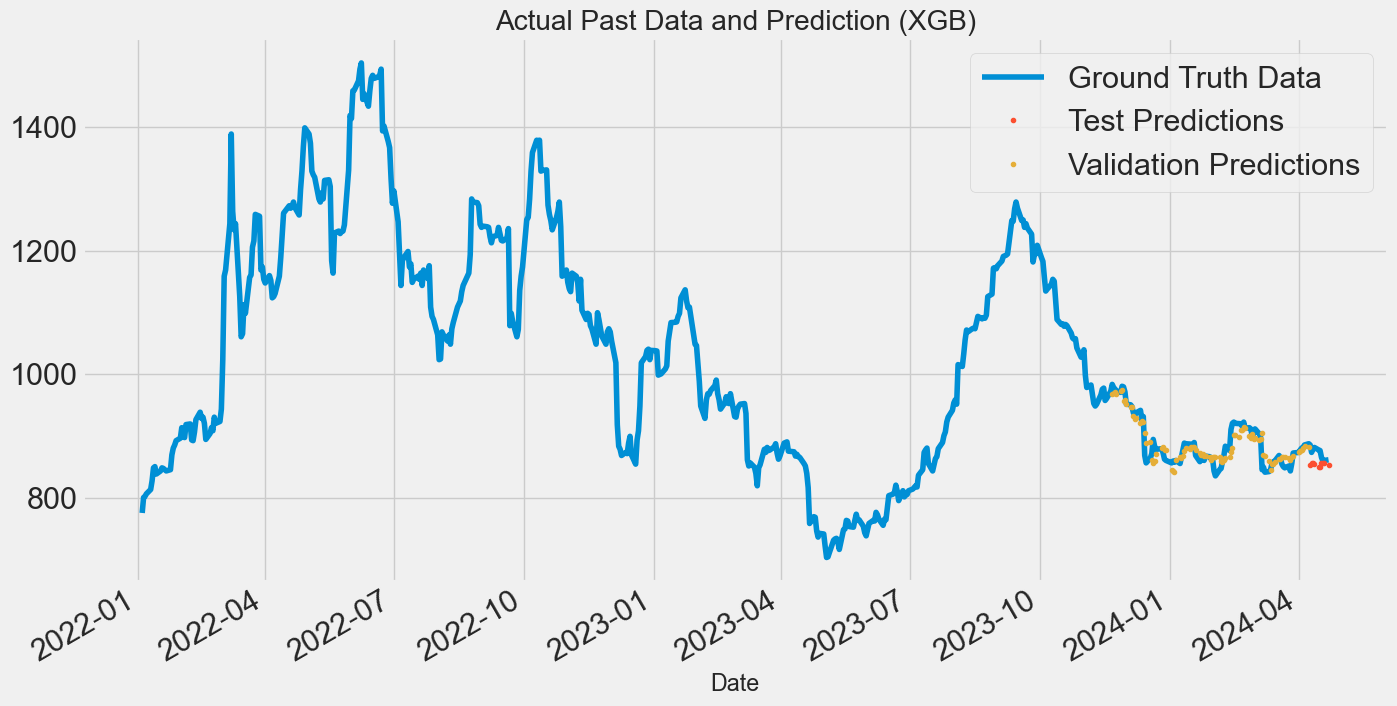

In [99]:
ax = ts1['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts1['prediction_xgb_cv'].plot(ax=ax, style='.')
ts1['prediction_xgb_val_cv'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

In [100]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts1_clean = ts1.dropna(subset=['prediction_xgb_val_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts1_clean['Marine Gasoil 9_Price'], ts1_clean['prediction_xgb_val_cv'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts1_clean['Marine Gasoil 9_Price'], ts1_clean['prediction_xgb_val_cv']))
score_mape_xgb_val = mean_absolute_percentage_error(ts1_clean['Marine Gasoil 9_Price'], ts1_clean['prediction_xgb_val_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 11.25
RMSE Score on Validation set (XGB): 15.36
MAPE Score on Validation set (XGB): 1.27%


In [101]:
ts1_clean = ts1.dropna(subset=['prediction_xgb_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts1_clean['Marine Gasoil 9_Price'], ts1_clean['prediction_xgb_cv'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts1_clean['Marine Gasoil 9_Price'], ts1_clean['prediction_xgb_cv']))
score_mape_xgb = mean_absolute_percentage_error(ts1_clean['Marine Gasoil 9_Price'], ts1_clean['prediction_xgb_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 17.84
RMSE Score on Validation set (XGB): 20.51
MAPE Score on Validation set (XGB): 2.03%


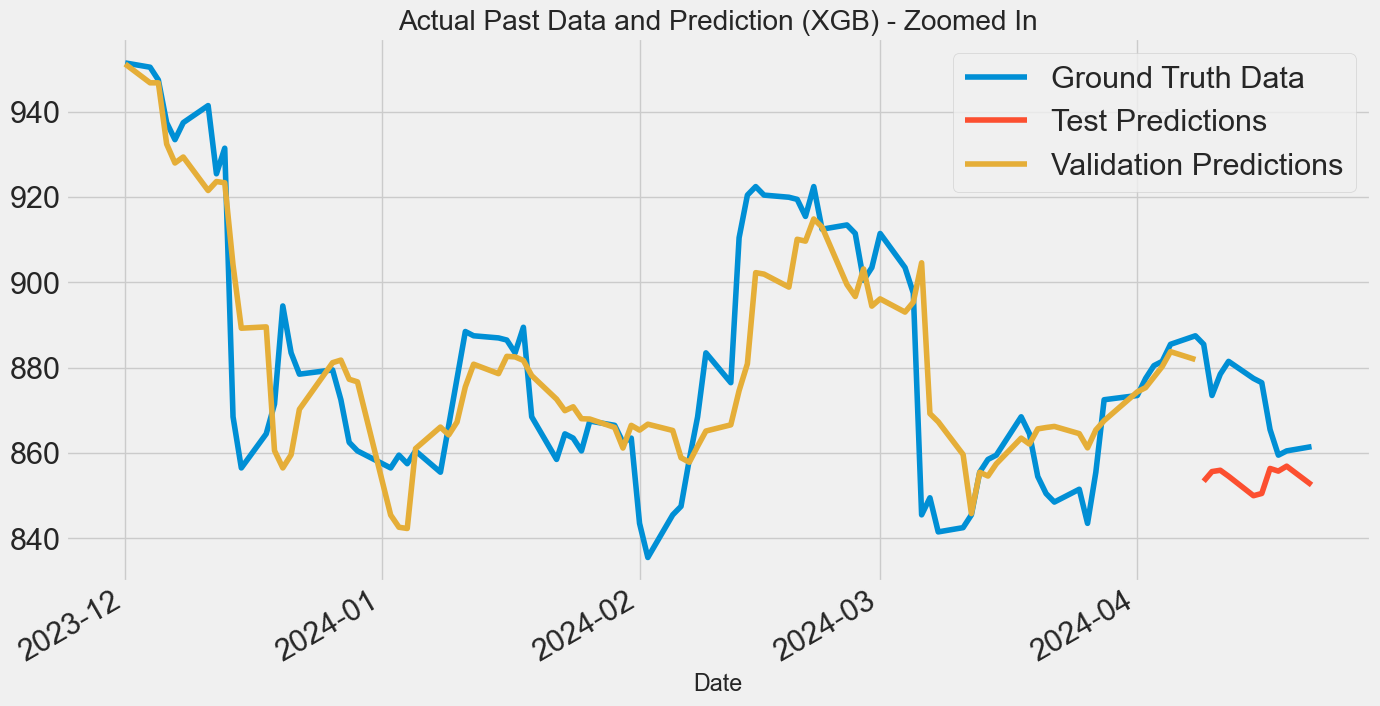

In [102]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-12-01'
end_date = '2024-05-01'

# 데이터 필터링
ts1_zoomed = ts1.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts1_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts1_zoomed['prediction_xgb_cv'].plot(ax=ax, style='-')
ts1_zoomed['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

## __Trial 2. Lag 일부 사용__

In [104]:
ts2 = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts2.index = pd.to_datetime(ts2.index)
ts2

Marine Gasoil 9_Price
Date                             
2022-01-04                  775.5
2022-01-05                  800.5
2022-01-06                  802.5
2022-01-07                  806.5
2022-01-10                  813.5
...                           ...
2024-04-16                  876.5
2024-04-17                  865.5
2024-04-18                  859.5
2024-04-19                  860.5
2024-04-22                  861.5

[595 rows x 1 columns]

In [105]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2, period=20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

In [106]:
last_date = ts2.index.max()

test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts2.loc[ts2.index <= test_start_date]
test = ts2.loc[ts2.index > test_start_date]

train_val.shape, test.shape

((585, 1), (10, 1))

In [107]:
train_val['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
train_val['seasonal'] = seasonal

test['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
test['seasonal'] = seasonal

train_val = add_rolling_mean(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
test = add_rolling_mean(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])

In [108]:
train_val = add_lags(train_val, 'Marine Gasoil 9_Price', [5, 10, 20])
test = add_lags(test, 'Marine Gasoil 9_Price', [5, 10, 20])

In [109]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [110]:
validation_start_date = test_start_date - pd.Timedelta(days=30)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']
tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

[0]	validation_0-rmse:1229.78463
[100]	validation_0-rmse:480.88697
[200]	validation_0-rmse:220.03093
[300]	validation_0-rmse:139.43178
[400]	validation_0-rmse:114.90328
[500]	validation_0-rmse:107.55615
[600]	validation_0-rmse:105.15093
[700]	validation_0-rmse:104.05164
[800]	validation_0-rmse:103.49238
[900]	validation_0-rmse:103.28335
[1000]	validation_0-rmse:103.21690
[1100]	validation_0-rmse:103.18967
[1113]	validation_0-rmse:103.17443
[0]	validation_0-rmse:1068.99740
[100]	validation_0-rmse:414.75149
[200]	validation_0-rmse:170.32480
[300]	validation_0-rmse:90.18679
[400]	validation_0-rmse:67.50860
[500]	validation_0-rmse:61.53257
[600]	validation_0-rmse:59.86841
[700]	validation_0-rmse:59.36686
[800]	validation_0-rmse:59.12026
[900]	validation_0-rmse:59.05813
[973]	validation_0-rmse:59.06499
[0]	validation_0-rmse:810.87249
[100]	validation_0-rmse:259.16339
[200]	validation_0-rmse:86.25674
[300]	validation_0-rmse:42.46818
[379]	validation_0-rmse:43.05526
[0]	validation_0-rmse:1058

In [111]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [78.36085116986146, 47.82215362234214, 36.05409665451836, 21.207903989811534, 11.53191886980509]
Average MAE across folds: 39.00
RMSE for each fold: [103.17084427951865, 59.04079064675593, 41.40445586687536, 26.55600687887731, 15.14409715742851]
Average RMSE across folds: 49.06
MAPE for each fold: [6.126403830957301, 4.6242666524934, 4.457343355976909, 2.0222465242152468, 1.3052684219207813]
Average MAPE across folds: 3.71


In [112]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:880.20474
[100]	validation_0-rmse:323.02253
[200]	validation_0-rmse:119.26818
[300]	validation_0-rmse:46.30421
[400]	validation_0-rmse:22.94688
[500]	validation_0-rmse:16.58043
[600]	validation_0-rmse:15.39827
[700]	validation_0-rmse:15.16631
[766]	validation_0-rmse:15.17992


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [113]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts2 = ts2.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts2 = ts2.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts2

Marine Gasoil 9_Price  prediction_xgb_val_cv  prediction_xgb_cv
Date                                                                       
2022-01-04                  775.5                    NaN                NaN
2022-01-05                  800.5                    NaN                NaN
2022-01-06                  802.5                    NaN                NaN
2022-01-07                  806.5                    NaN                NaN
2022-01-10                  813.5                    NaN                NaN
...                           ...                    ...                ...
2024-04-16                  876.5                    NaN         835.497498
2024-04-17                  865.5                    NaN         838.733765
2024-04-18                  859.5                    NaN         840.816895
2024-04-19                  860.5                    NaN         842.687317
2024-04-22                  861.5                    NaN         842.304321

[595 rows x 3 columns]

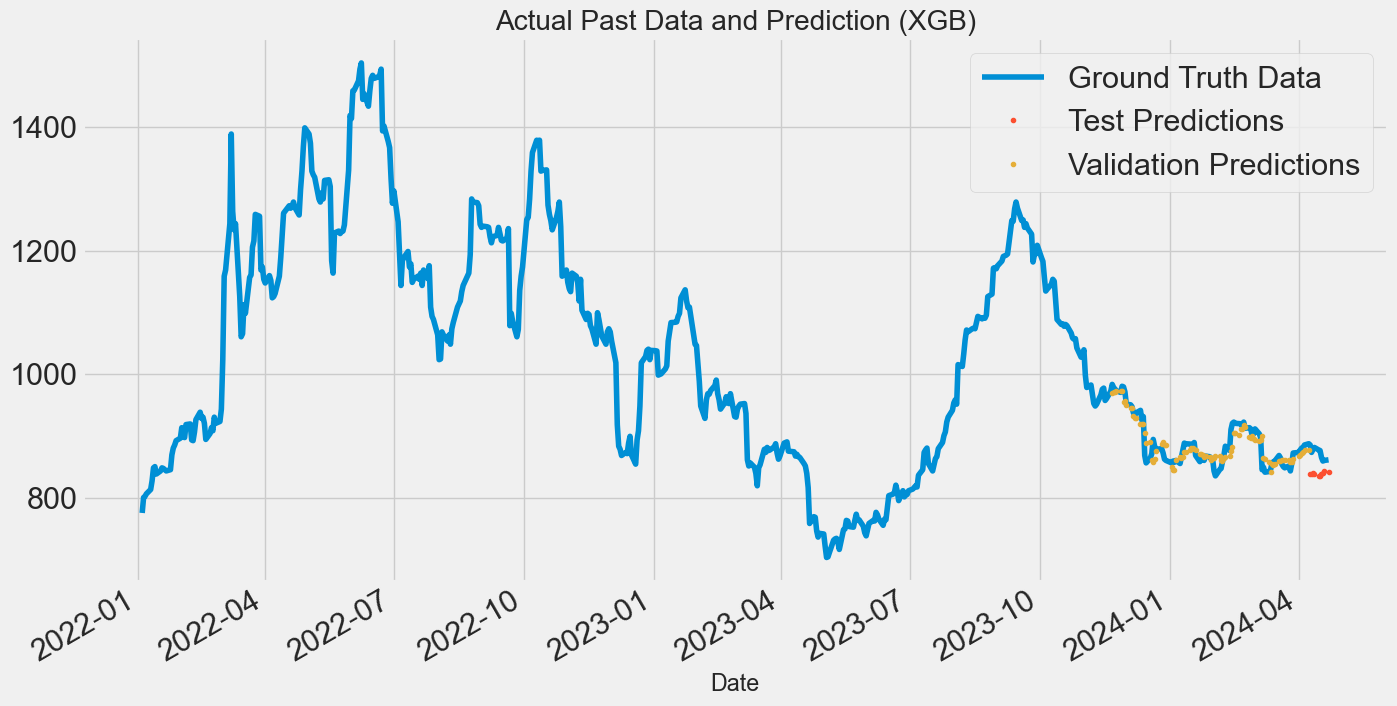

In [114]:
ax = ts2['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts2['prediction_xgb_cv'].plot(ax=ax, style='.')
ts2['prediction_xgb_val_cv'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

In [115]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts2_clean = ts2.dropna(subset=['prediction_xgb_val_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts2_clean['Marine Gasoil 9_Price'], ts2_clean['prediction_xgb_val_cv'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts2_clean['Marine Gasoil 9_Price'], ts2_clean['prediction_xgb_val_cv']))
score_mape_xgb_val = mean_absolute_percentage_error(ts2_clean['Marine Gasoil 9_Price'], ts2_clean['prediction_xgb_val_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 11.53
RMSE Score on Validation set (XGB): 15.14
MAPE Score on Validation set (XGB): 1.31%


In [116]:
ts2_clean = ts2.dropna(subset=['prediction_xgb_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts2_clean['Marine Gasoil 9_Price'], ts2_clean['prediction_xgb_cv'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts2_clean['Marine Gasoil 9_Price'], ts2_clean['prediction_xgb_cv']))
score_mape_xgb = mean_absolute_percentage_error(ts2_clean['Marine Gasoil 9_Price'], ts2_clean['prediction_xgb_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 32.84
RMSE Score on Validation set (XGB): 34.54
MAPE Score on Validation set (XGB): 3.75%


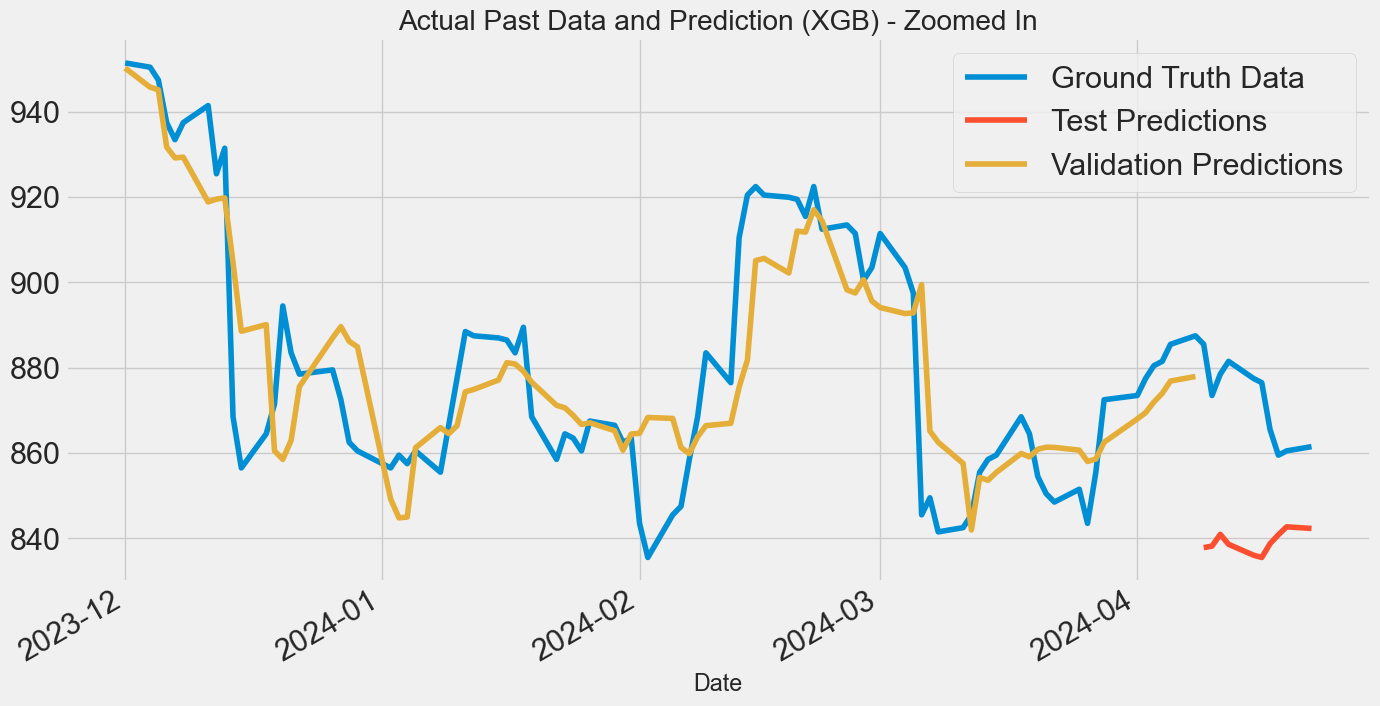

In [117]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-12-01'
end_date = '2024-05-01'

# 데이터 필터링
ts2_zoomed = ts2.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts2_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts2_zoomed['prediction_xgb_cv'].plot(ax=ax, style='-')
ts2_zoomed['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

## __Trial 3. SMA, Lag 일부 사용__

In [118]:
ts3 = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts3.index = pd.to_datetime(ts3.index)
ts3

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts3, period=20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

last_date = ts3.index.max()

test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts3.loc[ts3.index <= test_start_date]
test = ts3.loc[ts3.index > test_start_date]

train_val['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
train_val['seasonal'] = seasonal

test['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
test['seasonal'] = seasonal

train_val = add_rolling_mean(train_val, 'Marine Gasoil 9_Price', [5, 10, 20])
test = add_rolling_mean(test, 'Marine Gasoil 9_Price', [5, 10, 20])

train_val = add_lags(train_val, 'Marine Gasoil 9_Price', [5, 10, 20])
test = add_lags(test, 'Marine Gasoil 9_Price', [5, 10, 20])

train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

validation_start_date = test_start_date - pd.Timedelta(days=30)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']
tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

[0]	validation_0-rmse:1229.78463
[100]	validation_0-rmse:480.52721
[200]	validation_0-rmse:217.43149
[300]	validation_0-rmse:137.48469
[400]	validation_0-rmse:111.66797
[500]	validation_0-rmse:104.71629
[600]	validation_0-rmse:101.80713
[700]	validation_0-rmse:100.88841
[800]	validation_0-rmse:100.38680
[900]	validation_0-rmse:100.17088
[1000]	validation_0-rmse:100.08240
[1100]	validation_0-rmse:100.02283
[1115]	validation_0-rmse:100.00662
[0]	validation_0-rmse:1068.99740
[100]	validation_0-rmse:411.66809
[200]	validation_0-rmse:168.34729
[300]	validation_0-rmse:92.57029
[400]	validation_0-rmse:70.97128
[500]	validation_0-rmse:64.31234
[600]	validation_0-rmse:61.98933
[700]	validation_0-rmse:60.62148
[800]	validation_0-rmse:59.88922
[900]	validation_0-rmse:59.56493
[1000]	validation_0-rmse:59.46168
[1069]	validation_0-rmse:59.46143
[0]	validation_0-rmse:811.08028
[100]	validation_0-rmse:259.11652
[200]	validation_0-rmse:86.00932
[300]	validation_0-rmse:41.92161
[385]	validation_0-rmse:

[0]	validation_0-rmse:880.29629
[100]	validation_0-rmse:322.89659
[200]	validation_0-rmse:119.40570
[300]	validation_0-rmse:46.44699
[400]	validation_0-rmse:22.50718
[500]	validation_0-rmse:16.56410
[600]	validation_0-rmse:15.56257
[646]	validation_0-rmse:15.57211


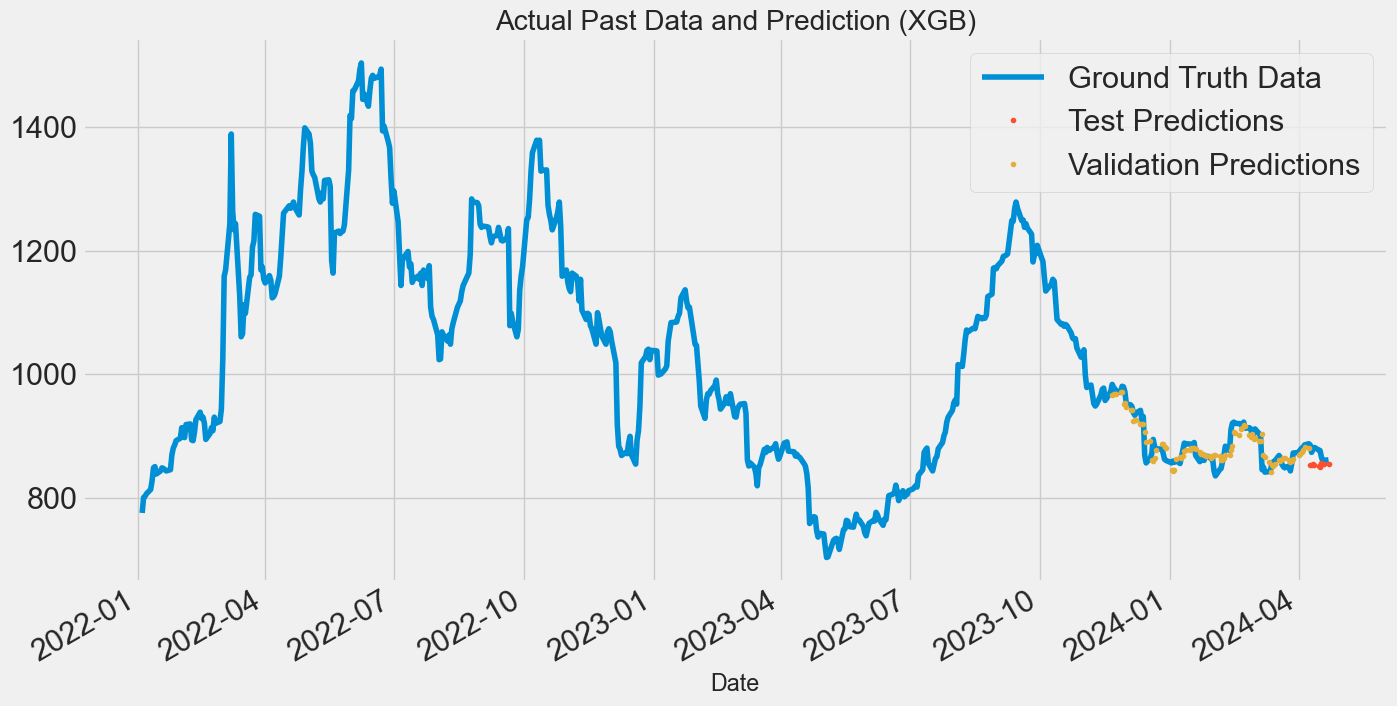

In [119]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts3 = ts3.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts3 = ts3.merge(pred_test_df, how='left', left_index=True, right_index=True)

ax = ts3['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts3['prediction_xgb_cv'].plot(ax=ax, style='.')
ts3['prediction_xgb_val_cv'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

In [120]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts3_clean = ts3.dropna(subset=['prediction_xgb_val_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts3_clean['Marine Gasoil 9_Price'], ts3_clean['prediction_xgb_val_cv'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts3_clean['Marine Gasoil 9_Price'], ts3_clean['prediction_xgb_val_cv']))
score_mape_xgb_val = mean_absolute_percentage_error(ts3_clean['Marine Gasoil 9_Price'], ts3_clean['prediction_xgb_val_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

ts3_clean = ts3.dropna(subset=['prediction_xgb_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts3_clean['Marine Gasoil 9_Price'], ts3_clean['prediction_xgb_cv'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts3_clean['Marine Gasoil 9_Price'], ts3_clean['prediction_xgb_cv']))
score_mape_xgb = mean_absolute_percentage_error(ts3_clean['Marine Gasoil 9_Price'], ts3_clean['prediction_xgb_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 11.99
RMSE Score on Validation set (XGB): 15.56
MAPE Score on Validation set (XGB): 1.36%
MAE Score on Validation set (XGB): 18.58
RMSE Score on Validation set (XGB): 21.11
MAPE Score on Validation set (XGB): 2.12%


## __Trial 4. SMA, lag에 bfill, ffill 제외__

In [121]:
ts4 = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts4.index = pd.to_datetime(ts4.index)
ts4

Marine Gasoil 9_Price
Date                             
2022-01-04                  775.5
2022-01-05                  800.5
2022-01-06                  802.5
2022-01-07                  806.5
2022-01-10                  813.5
...                           ...
2024-04-16                  876.5
2024-04-17                  865.5
2024-04-18                  859.5
2024-04-19                  860.5
2024-04-22                  861.5

[595 rows x 1 columns]

In [122]:
last_date = ts4.index.max()

test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts4.loc[ts4.index <= test_start_date]
test = ts4.loc[ts4.index > test_start_date]

In [125]:
train_val['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
train_val['seasonal'] = seasonal

test['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
test['seasonal'] = seasonal

In [127]:

# 이동평균을 추가하는 함수
def add_rolling_mean(df:pd.DataFrame, col_name:str, window_list:list)->pd.DataFrame:
    for window in window_list:
        df[col_name + f'_rolling{window}'] = df[col_name].rolling(window).mean()
    return df

# 5일(1주), 10일(2주), 20일(1개월), 60일(3개월), 120일(6개월), 240일(1년) 이동평균 추가
train_val = add_rolling_mean(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
test = add_rolling_mean(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])

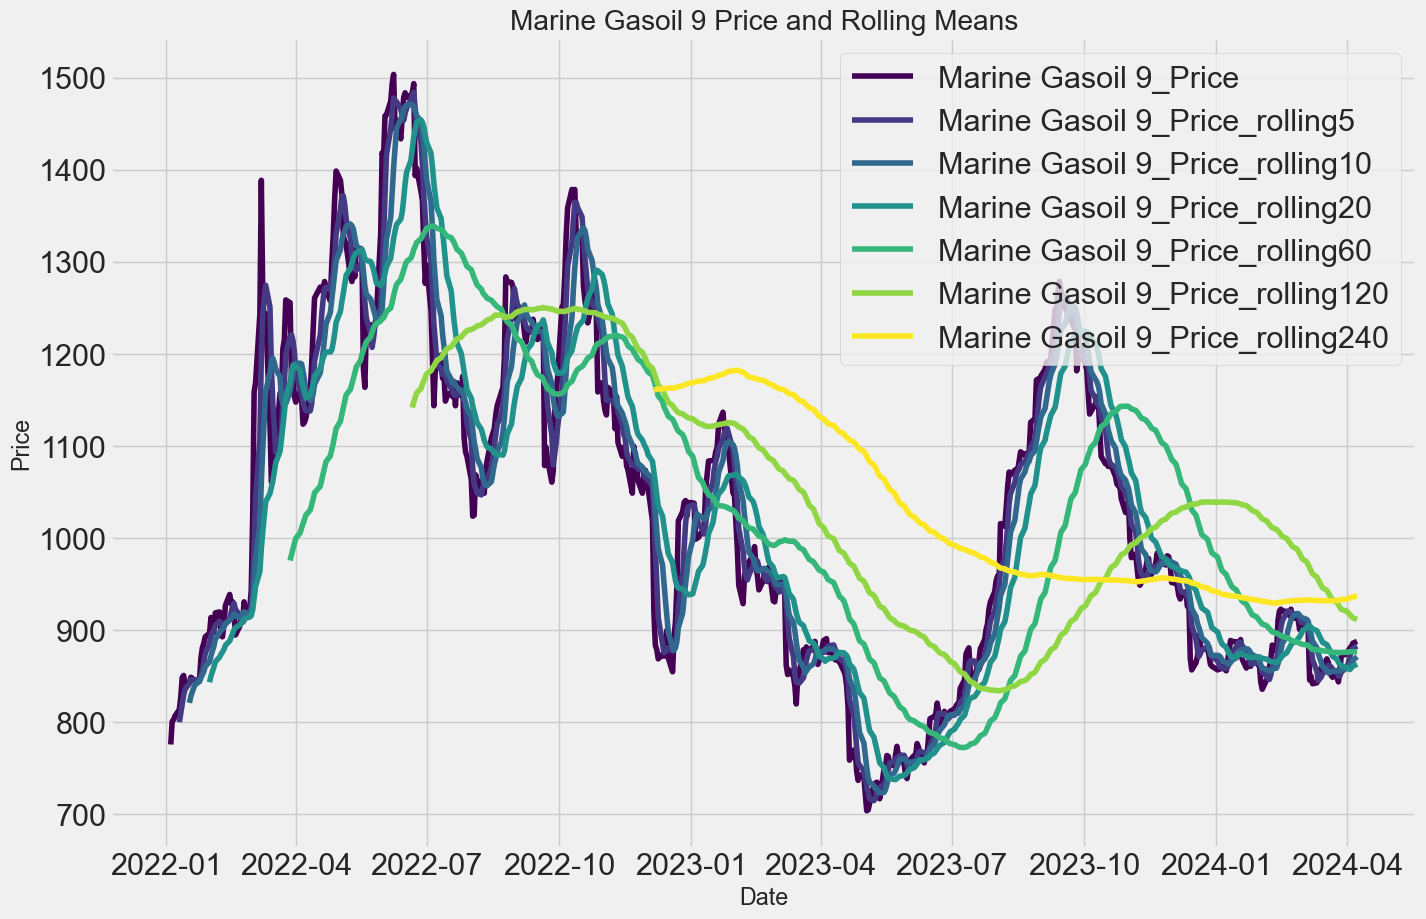

In [128]:
columns_to_plot = [
    'Marine Gasoil 9_Price',
    'Marine Gasoil 9_Price_rolling5',
    'Marine Gasoil 9_Price_rolling10',
    'Marine Gasoil 9_Price_rolling20',
    'Marine Gasoil 9_Price_rolling60',
    'Marine Gasoil 9_Price_rolling120',
    'Marine Gasoil 9_Price_rolling240'
]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [131]:
def add_lags(df: pd.DataFrame, col_name: str, lag_days_list: list) -> pd.DataFrame:
    target_map = df[col_name].to_dict()
    for days in lag_days_list:
        df[f'{col_name}_lag{days}'] = (df.index - pd.Timedelta(days=days)).map(target_map)
    df = df.fillna(method='ffill')
    return df

train_val = add_lags(train_val, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240, 480])
test = add_lags(test, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240, 480])

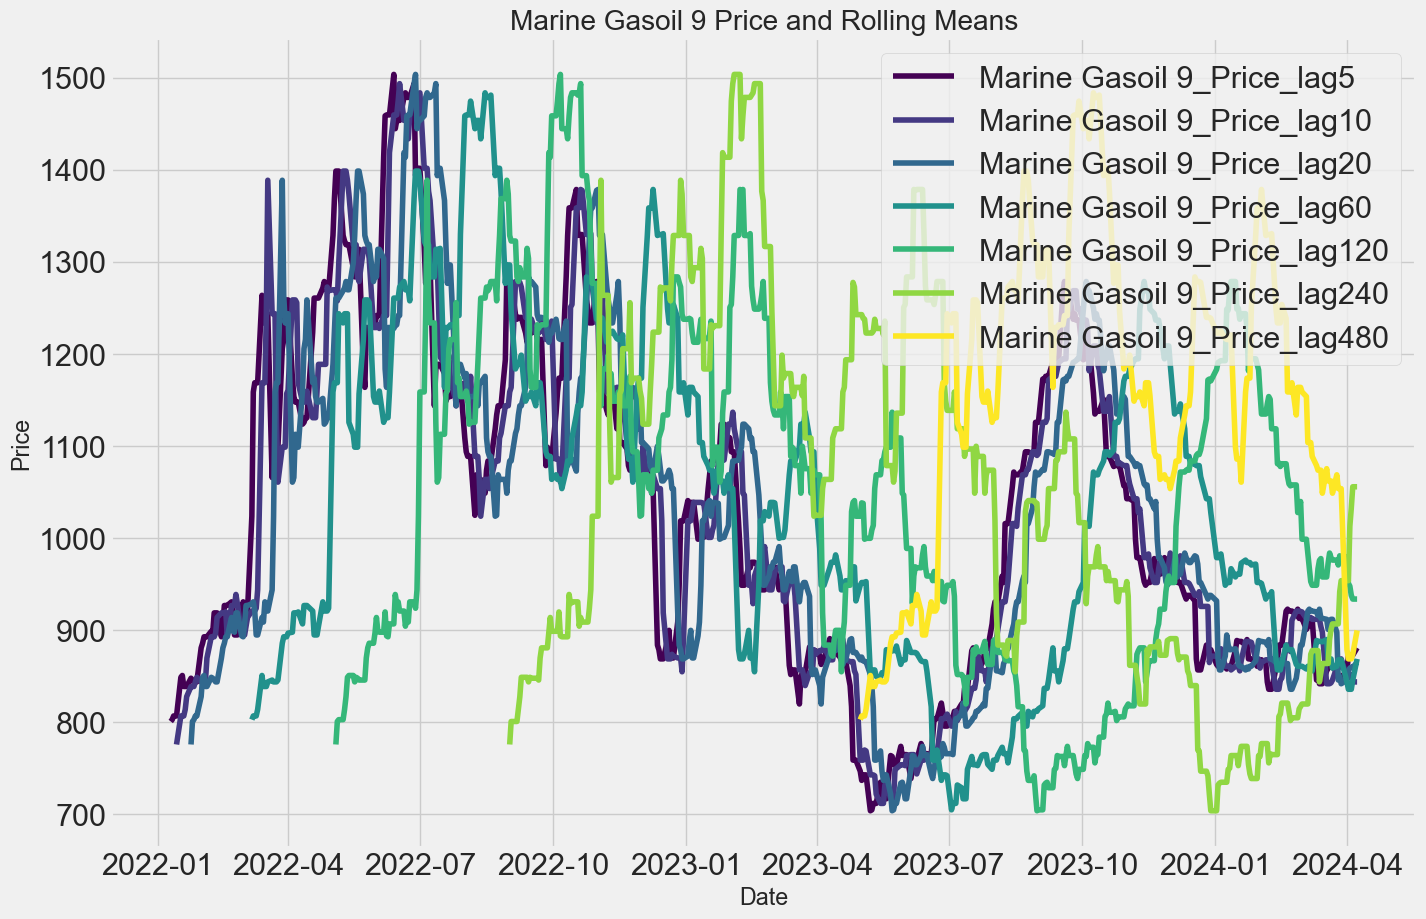

In [132]:
columns_to_plot = [
    'Marine Gasoil 9_Price_lag5',
    'Marine Gasoil 9_Price_lag10',
    'Marine Gasoil 9_Price_lag20',
    'Marine Gasoil 9_Price_lag60',
    'Marine Gasoil 9_Price_lag120',
    'Marine Gasoil 9_Price_lag240',
    'Marine Gasoil 9_Price_lag480'
]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [133]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

In [134]:
validation_start_date = test_start_date - pd.Timedelta(days=30)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [135]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']
tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

[0]	validation_0-rmse:1229.78463
[100]	validation_0-rmse:480.27958
[200]	validation_0-rmse:217.66777
[300]	validation_0-rmse:140.06034
[400]	validation_0-rmse:113.90889
[500]	validation_0-rmse:105.84776
[600]	validation_0-rmse:101.96201
[700]	validation_0-rmse:100.24725
[800]	validation_0-rmse:99.41822
[900]	validation_0-rmse:98.97023
[1000]	validation_0-rmse:98.76380
[1100]	validation_0-rmse:98.66321
[1200]	validation_0-rmse:98.60594
[1300]	validation_0-rmse:98.58379
[1397]	validation_0-rmse:98.57534
[0]	validation_0-rmse:1068.99740
[100]	validation_0-rmse:397.61477
[200]	validation_0-rmse:154.95080
[300]	validation_0-rmse:79.40872
[400]	validation_0-rmse:56.79546
[500]	validation_0-rmse:51.08731
[600]	validation_0-rmse:49.65247
[700]	validation_0-rmse:49.12565
[800]	validation_0-rmse:48.94788
[827]	validation_0-rmse:48.98042
[0]	validation_0-rmse:811.08028
[100]	validation_0-rmse:257.80640
[200]	validation_0-rmse:83.30818
[300]	validation_0-rmse:47.37843
[360]	validation_0-rmse:50.71

In [136]:
# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val_cv'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb_cv'])

ts4 = ts4.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts4 = ts4.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts4

[0]	validation_0-rmse:880.28922
[100]	validation_0-rmse:323.95725
[200]	validation_0-rmse:120.40092
[300]	validation_0-rmse:46.67096
[400]	validation_0-rmse:23.63641
[500]	validation_0-rmse:17.34169
[600]	validation_0-rmse:15.93288
[700]	validation_0-rmse:15.47171
[800]	validation_0-rmse:15.31917
[900]	validation_0-rmse:15.27538
[959]	validation_0-rmse:15.27687


Marine Gasoil 9_Price  prediction_xgb_val_cv  prediction_xgb_cv
Date                                                                       
2022-01-04                  775.5                    NaN                NaN
2022-01-05                  800.5                    NaN                NaN
2022-01-06                  802.5                    NaN                NaN
2022-01-07                  806.5                    NaN                NaN
2022-01-10                  813.5                    NaN                NaN
...                           ...                    ...                ...
2024-04-16                  876.5                    NaN         863.758301
2024-04-17                  865.5                    NaN         865.618042
2024-04-18                  859.5                    NaN         864.211975
2024-04-19                  860.5                    NaN         861.437744
2024-04-22                  861.5                    NaN         878.378357

[595 rows x 3 columns]

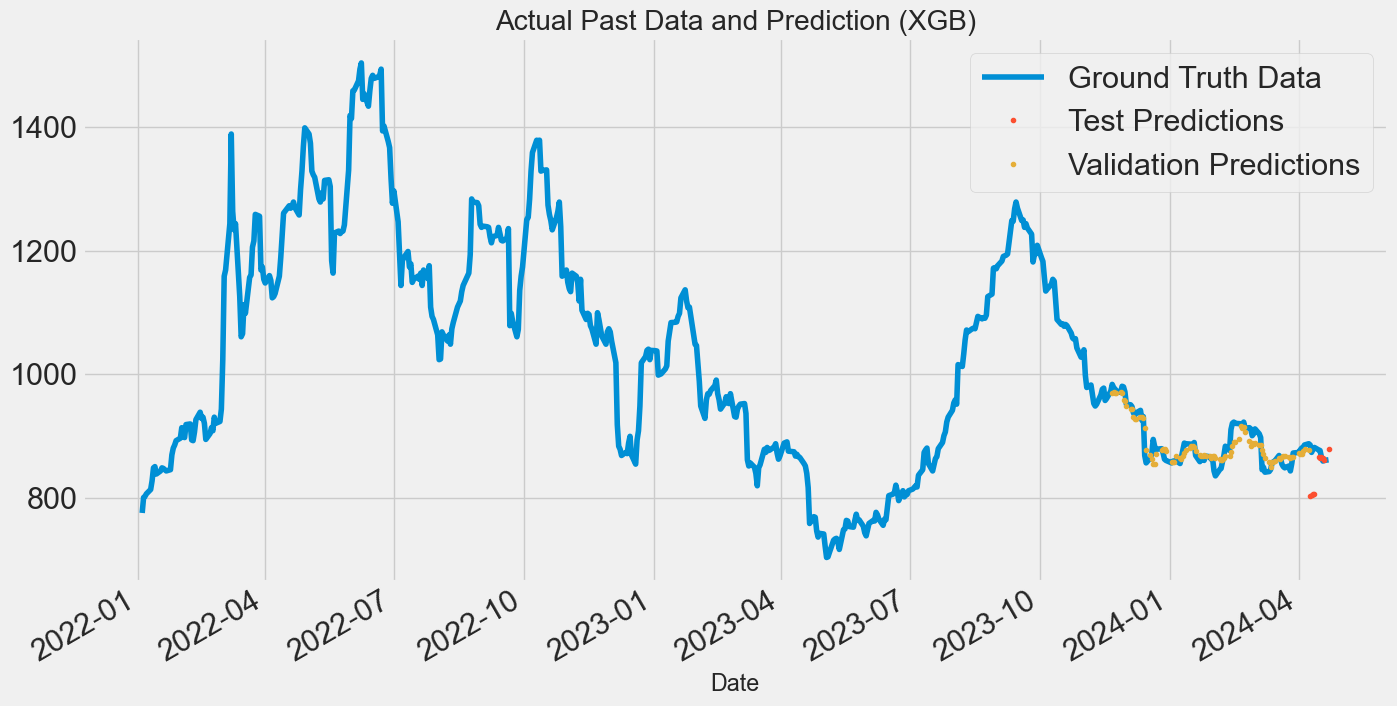

In [137]:
ax = ts4['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts4['prediction_xgb_cv'].plot(ax=ax, style='.')
ts4['prediction_xgb_val_cv'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

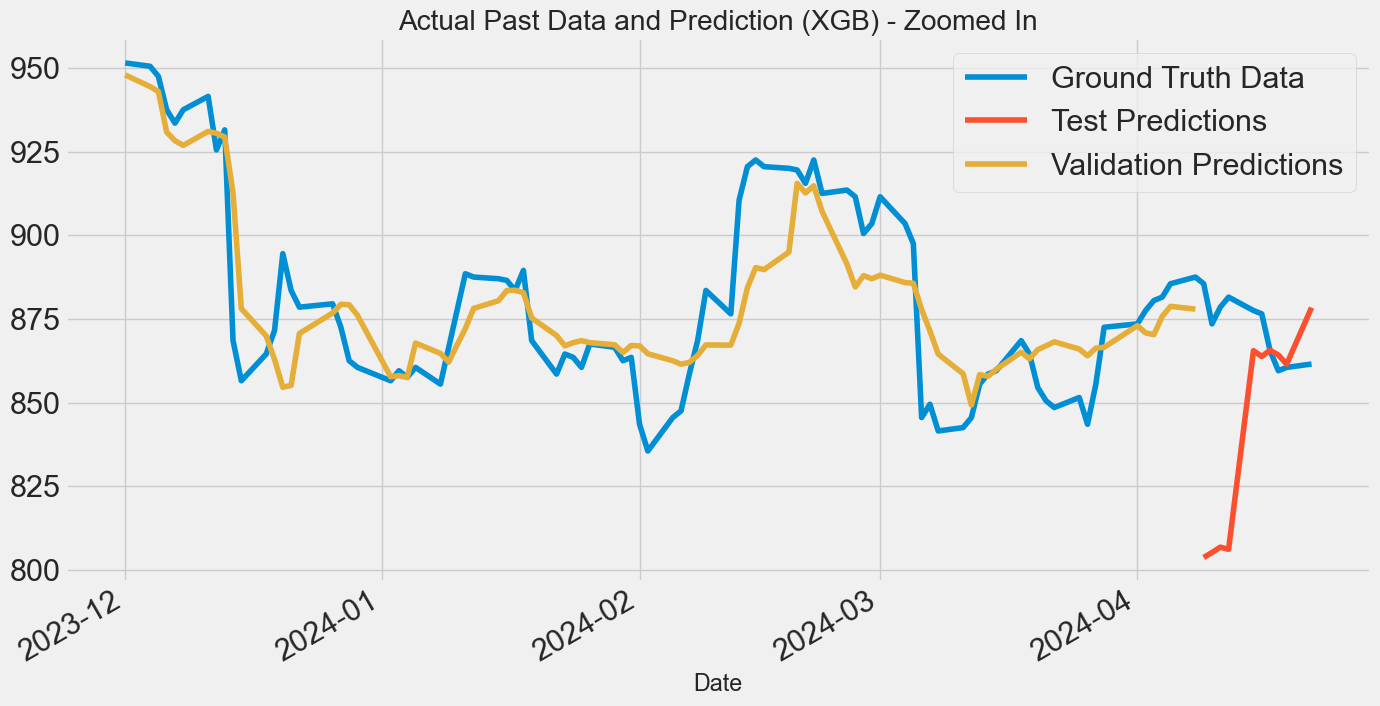

In [138]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-12-01'
end_date = '2024-05-01'

# 데이터 필터링
ts4_zoomed = ts4.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts4_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts4_zoomed['prediction_xgb_cv'].plot(ax=ax, style='-')
ts4_zoomed['prediction_xgb_val_cv'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

In [139]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts4_clean = ts4.dropna(subset=['prediction_xgb_val_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts4_clean['Marine Gasoil 9_Price'], ts4_clean['prediction_xgb_val_cv'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts4_clean['Marine Gasoil 9_Price'], ts4_clean['prediction_xgb_val_cv']))
score_mape_xgb_val = mean_absolute_percentage_error(ts4_clean['Marine Gasoil 9_Price'], ts4_clean['prediction_xgb_val_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 11.56
RMSE Score on Validation set (XGB): 15.26
MAPE Score on Validation set (XGB): 1.30%


In [141]:
ts4_clean = ts4.dropna(subset=['prediction_xgb_cv', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts4_clean['Marine Gasoil 9_Price'], ts4_clean['prediction_xgb_cv'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts4_clean['Marine Gasoil 9_Price'], ts4_clean['prediction_xgb_cv']))
score_mape_xgb = mean_absolute_percentage_error(ts4_clean['Marine Gasoil 9_Price'], ts4_clean['prediction_xgb_cv'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 34.47
RMSE Score on Validation set (XGB): 47.76
MAPE Score on Validation set (XGB): 3.92%


In [142]:
test

Marine Gasoil 9_Price    trend  seasonal  \
Date                                                   
2024-04-09                  885.5  871.125 -2.680333   
2024-04-10                  873.5  871.125 -2.934797   
2024-04-11                  878.5  871.125 -2.422594   
2024-04-12                  881.5  871.125 -5.157713   
2024-04-15                  877.5  871.125 -5.649083   
2024-04-16                  876.5  871.125 -8.482262   
2024-04-17                  865.5  871.125 -3.621917   
2024-04-18                  859.5  871.125 -0.534848   
2024-04-19                  860.5  871.125  4.334692   
2024-04-22                  861.5  871.125  6.254520   

            Marine Gasoil 9_Price_rolling5  Marine Gasoil 9_Price_rolling10  \
Date                                                                          
2024-04-09                             NaN                              NaN   
2024-04-10                             NaN                              NaN   
2024-04-11                             NaN                              NaN   
2024-04-12                             NaN                              NaN   
2024-04-15                           879.3                              NaN   
2024-04-16                           877.5                              NaN   
2024-04-17                           875.9                              NaN   
2024-04-18                           872.1                              NaN   
2024-04-19                           867.9                              NaN   
2024-04-22                           864.7                            872.0   

            Marine Gasoil 9_Price_rolling20  Marine Gasoil 9_Price_rolling60  \
Date                                                                           
2024-04-09                              NaN                              NaN   
2024-04-10                              NaN                              NaN   
2024-04-11                              NaN                              NaN   
2024-04-12                              NaN                              NaN   
2024-04-15                              NaN                              NaN   
2024-04-16                              NaN                              NaN   
2024-04-17                              NaN                              NaN   
2024-04-18                              NaN                              NaN   
2024-04-19                              NaN                              NaN   
2024-04-22                              NaN                              NaN   

            Marine Gasoil 9_Price_rolling120  \
Date                                           
2024-04-09                               NaN   
2024-04-10                               NaN   
2024-04-11                               NaN   
2024-04-12                               NaN   
2024-04-15                               NaN   
2024-04-16                               NaN   
2024-04-17                               NaN   
2024-04-18                               NaN   
2024-04-19                               NaN   
2024-04-22                               NaN   

            Marine Gasoil 9_Price_rolling240  Marine Gasoil 9_Price_lag5  ...  \
Date                                                                      ...   
2024-04-09                               NaN                         NaN  ...   
2024-04-10                               NaN                         NaN  ...   
2024-04-11                               NaN                         NaN  ...   
2024-04-12                               NaN                         NaN  ...   
2024-04-15                               NaN                       873.5  ...   
2024-04-16                               NaN                       878.5  ...   
2024-04-17                               NaN                       881.5  ...   
2024-04-18                               NaN                       881.5  ...   
2024-04-19                               N